# Load Libraries

In [1]:
import sys, os, pygmt, importlib, re, time, glob, io
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox, SeaIceToolboxManager
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from dask.diagnostics     import ProgressBar
from pyproj               import CRS, Transformer
from collections          import defaultdict
from scipy.interpolate    import interp1d
from tqdm                 import tqdm        
import numpy                as np
import pandas               as pd
import xarray               as xr
import xesmf                as xe
import matplotlib.pyplot    as plt
import matplotlib.dates     as mdates
import matplotlib.animation as animation
from IPython.display      import Image, HTML, Video
import warnings
warnings.filterwarnings("ignore", message="Sending large graph of size", category=UserWarning, module="distributed.client")
from pyproj import Transformer
from pyresample.geometry import AreaDefinition, SwathDefinition
from pyresample.kd_tree import resample_nearest

## reload SeaIceToolbox if local changes have been made

In [ ]:
import sys
import importlib
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
from sea_ice_toolbox import SeaIceToolbox, SeaIceToolboxManager

# [Simulation Table](https://dpath2o.github.io/AFIM/ice_diag_summary.html)

# [Methodology](https://dpath2o.github.io/AFIM/AFIM_sensitivity_methodology.html)

# ACCESS-OM2-025-ERA5 sea ice data ( **needs only to be run once, after which data can be extracted from local zarr files** )
+ this uses [ACCESS-NRI intake catalog](https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html) through a ``SeaIceToolbox`` method ``load_ACCESS_OM_CICE``

In [ ]:
dt0_str        = "2000-01-01"
dtN_str        = "2023-12-31"
dt_rng_str     = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type       = "FI_BT"
SIA_dict       = {}
FIA_dict       = {}
SI_tools       = SeaIceToolbox(sim_name             = "AOM2-ERA5",
                               dt0_str              = dt0_str,
                               dtN_str              = dtN_str,
                               ice_speed_threshold  = 5e-4,
                               ice_speed_type       = "BT",
                               ice_type             = "FI_BT",
                               overwrite_zarr       = False,
                               save_new_figs        = True,
                               show_figs            = True,
                               overwrite_saved_figs = True)

## load ACCESS-OM-025-ERA5 data from ESM datastore then convert to zarr files for easy of use later
+ loading and saving only needs to be done if it has not been done previously
+ running both of these cells takes approximately an hour with the bottleneck at writing to zarr

In [ ]:
AOM2 = SI_tools.load_ACCESS_OM_CICE()

In [ ]:
SI_tools.write_ACCESS_to_monthly_zarr(AOM2)

## run ACCESS-OM-025-ERA5 through fast ice classification workflow
+ this is a quick process and will save masked zarr dataset

In [ ]:
AOM2_FI_raw = SI_tools.process_daily_cice(ispd_thresh=5e-4,
                                          ivec_type="BT",
                                          overwrite_zarr_group=True)

In [ ]:
AOM2_FI_roll = SI_tools.process_rolling_cice(ispd_thresh=5e-4,
                                             ivec_type="BT",
                                             overwrite_zarr_group=True)

# <span style="color: red;">Study Objectives</span>

# Can a realistic simulation of circumpolar Antarctic fast ice be achieved in CICE-standalone?

+ Sea ice area and volum comparisons are done against [NSIDC](https://nsidc.org/data/g02202/versions/4) and [ACCESS-OM2-025-IAF-ERA](https://forum.access-hive.org.au/t/era-5-forced-access-om2-simulations/1103) (``AOM2-ERA``). The rationale is to show two of my simulations ([AFIM](https://github.com/dpath2o/AFIM), *CICE6-standalone*) against both NSIDC and ACCESS-OM2 as a relative overall gauge of AFIM performance.

+ I've chosen two related AFIM simulations: ``elps-min`` and ``gi-nil``. Both of which have ellispse eccentrincities ($e_{f}=e_{g}=1.2$, and further just abbreviated $e$) and tensile stress parameter ($k_{t}=0.2$) and all other CICE namelist parameters set to *default* standalone configuration, with the exception of the landmask file used (``kmt_file``). ``elps-min`` uses a modified landmask where 25% of the non-isolated grounded iceberg cells remain, whereas ``gi-nil`` uses the same landmask file as ``AOM2-ERA5`` and hence has no grounded iceberg cells.
  
+ Animations of daily sea ice speed ($\sqrt{u^2 + v^2}$) are then shown of the above two AFIM simulations along with AOM2-ERA5 for the same period (Austral winter 1999). Implicitly, the animations show the effect of $e$ and $ktens$ on the coastal icepack, and for the ``elps-min`` simulation the animation clearly shows the significance of grouned icebergs. 

## Southern Ocean Pack/Fast Ice Area, Volume, Thickness and Drift/Speed Comparisons
+ run the script:
```bash qsub ./scripts/all_stats.pbs```

In [ ]:
def load_ispd_diffs(sim_name):
    D_search = Path(Path.home(), "seaice", "OSI_SAF", "ice_drift_455m")
    F_search = "ispd_diffs_pygmt_nn_{sim}_199*.nc".format(sim=sim_name)
    P_       = sorted(D_search.rglob(F_search))
    return xr.open_mfdataset(P_, combine="by_coords")
ISP_bias             = {}
ISP_rmse             = {}
ISP_ang              = {}
ISP_cos              = {}
ds                   = load_ispd_diffs("elps-min")
ISP_bias['elps-min'] = {'ispd_bias'  : ds['d_ispd_CICE'].mean(dim=['ny','nx']).compute()}#.groupby('time.dayofyear').mean('time').mean(dim=['ny','nx']).compute(),
ISP_rmse['elps-min'] = {'ispd_rmse'  : ds['RMSE_CICE']}#.groupby('time.dayofyear').mean('time').compute(),
ISP_ang['elps-min']  = {'ang_bias'   : ds['ANG_CICE_mean']}#.groupby('time.dayofyear').mean('time').compute(),
ISP_cos['elps-min']  = {'cos_bias'   : ds['COS_CICE_mean']}#.groupby('time.dayofyear').mean('time').compute(),
                         #'line_color' : 'red'}
ISP_bias['AOM2-ERA5'] = {'ispd_bias'  : ds['d_ispd_AOM2'].mean(dim=['ny','nx']).compute()}#.groupby('time.dayofyear').mean('time').mean(dim=['ny','nx']).compute(),
ISP_rmse['AOM2-ERA5'] = {'ispd_rmse'  : ds['RMSE_AOM2']}#.groupby('time.dayofyear').mean('time').compute(),
ISP_ang['AOM2-ERA5']  = {'ang_bias'   : ds['ANG_AOM2_mean']}#.groupby('time.dayofyear').mean('time').compute(),
ISP_cos['AOM2-ERA5']  = {'cos_bias'   : ds['COS_AOM2_mean']}#.groupby('time.dayofyear').mean('time').compute(),
                         #'line_color' : 'green'}

In [ ]:
ISP_bias['ORAS'] = {'ispd_bias'  : ds['d_ispd_ORAS'].mean(dim=['ny','nx']).compute()}#.groupby('time.dayofyear').mean('time').mean(dim=['ny','nx']).compute(),
ISP_rmse['ORAS'] = {'ispd_rmse'  : ds['RMSE_ORAS']}#.groupby('time.dayofyear').mean('time').compute(),
ISP_ang['ORAS']  = {'ang_bias'   : ds['ANG_ORAS_mean']}#.groupby('time.dayofyear').mean('time').compute(),
ISP_cos['ORAS']  = {'cos_bias'   : ds['COS_ORAS_mean']}#.groupby('time.dayofyear').mean('time').compute(),
                         #'line_color' : 'orange'}
ds                     = load_ispd_diffs("notensnogi")
ISP_bias['notensnogi'] = {'ispd_bias'  : ds['d_ispd_CICE'].mean(dim=['ny','nx']).compute()}#.groupby('time.dayofyear').mean('time').mean(dim=['ny','nx']).compute(),
ISP_rmse['notensnogi'] = {'ispd_rmse'  : ds['RMSE_CICE']}#.groupby('time.dayofyear').mean('time').compute(),
ISP_ang['notensnogi']  = {'ang_bias'   : ds['ANG_CICE_mean']}#.groupby('time.dayofyear').mean('time').compute(),
ISP_cos['notensnogi']  = {'cos_bias'   : ds['COS_CICE_mean']}#.groupby('time.dayofyear').mean('time').compute(),
                         #'line_color' : 'pink'}

In [ ]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
sim_tools   = SI_tool_mgr.get_toolbox(sim_name, dt0_str=dt0_str, dtN_str=dtN_str)
sim_tools.pygmt_timeseries(ISP_cos,
                        comp_name    = "ISP_cos_bias",
                        primary_key  = "cos_bias",
                        climatology  = True,
                        ylabel       = "Sea Ice Drift Cosine Simality",
                        ylim         = [-.6,.6],
                        ytick_pri    = .1,
                        ytick_sec    = .05,
                           legend_pos = "JBC+jBC+o0.2c+w5c",
                          show_fig   = True)

In [ ]:
Image(filename='/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/SIV_elps-min_gi-nil_AOM2-ERA5_1994-1999.png')

<a id="spatial-comparisons"></a>
### Spatial Comaprisons 

#### Hemisphere comparisons of sea ice concentration and sea ice thickness

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

##### ``AOM2-ERA5``: e = 2, ktens = None, gi-min = None

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/AOM2-ERA5_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

##### ``gi-nil``: e = 2, ktens = 0.2, gi-min = None

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/gi-nil_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

## Which is the best method for computing fast ice: binary-day or rolling-mean?

+ create a dictionary of circumpolar fast ice area time series for one simulation (``elps-min``) for a range of different ``binary-day`` and ``rolling-mean`` configurations
+ calculate relevant statistical skills for each configuration against fast ice area observations (``AF2020``)
+ come up with a metric (normalisation-score) for determining the best performing configuration

In [ ]:
FIA_dict   = {}
FIV_dict   = {}
# P_dict     = {}
# divu_dict  = {}
# dvidtt_dict= {}
sim_name   = "elps-min"
dt0_str    = "1994-01-01"
dtN_str    = "1999-12-31"
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str)

In [ ]:
FI_raw, CICE = SI_tools.load_processed_cice( zarr_CICE = True )

#### compute binary-days 
+ this will be binary-days for 7 out of 7, 6 out of 7, 5 out of 7, 8 out of 8, 7 out of 8, 6 out of 8, and so on, until 13 out of 15.
  

In [ ]:
CICE_SO = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
for win in np.arange(7, 16):  # window sizes: 7 to 15 inclusive
    for cnt in np.arange(win, win - 3, -1):  # max, max-1, max-2 (e.g., 7,6,5)
        key_name = f"elps-min_bin-day_{cnt}of{win}"
        FI_bool               = SI_tools.boolean_fast_ice(FI_raw['FI_mask'], window=win, min_count=cnt)
        aice_bool             = CICE_SO['aice'].where(FI_bool)
        hi_bool               = CICE_SO['hi'].where(FI_bool)
        tarea_bool            = CICE_SO['tarea'].where(FI_bool)
        #P_bool                = CICE_SO['strength'].where(FI_bool)
        #divu_bool             = CICE_SO['divu'].where(FI_bool)
        #dvidtt_bool           = CICE_SO['dvidtt'].where(FI_bool)
        FIA_dict[key_name]    = SI_tools.compute_ice_area(FI_bool, tarea_bool)
        FIV_dict[key_name]    = SI_tools.compute_ice_volume(FI_bool, hi_bool, tarea_bool)
        #P_dict[key_name]      = P_bool.sum(dim=('nj','ni'))
        #divu_dict[key_name]   = divu_bool.sum(dim=('nj','ni'))
        #dvidtt_dict[key_name] = dvidtt_bool.sum(dim=('nj','ni'))

#### compute rolling-mean

+ this will be rolling-means over 7, 10, 13, 16 and 19 day periods
+ then compute FIA on each of those

In [ ]:
for i in np.arange(7,20,3):
    roll_name  = f"elps-min_roll-day_{i:d}"
    CICE_rolls = SI_tools.process_rolling_cice(sim_name         = sim_name,
                                               dt0_str          = dt0_str,
                                               dtN_str          = dtN_str,
                                               mean_period      = i,
                                               ivec_type        = "BT",
                                               write_zarr_group = False)
    FIA_dict[roll_name]    = SI_tools.compute_ice_area(CICE_rolls['FI_mask'], CICE_rolls['tarea'])
    FIV_dict[roll_name]    = SI_tools.compute_ice_volume(CICE_rolls['FI_mask'], CICE_rolls['hi'], CICE_rolls['tarea'])
    #P_FI_roll              = CICE_rolls['strength'].where(CICE_rolls['FI_mask'])
    #divu_FI_roll           = CICE_rolls['divu'].where(CICE_rolls['FI_mask'])
    #dvidtt_FI_roll         = CICE_rolls['dvidtt'].where(CICE_rolls['FI_mask'])
    #P_dict[roll_name]      = P_FI_roll.sum(dim=('nj','ni'))
    #divu_dict[roll_name]   = divu_FI_roll.sum(dim=('nj','ni'))
    #dvidtt_dict[roll_name] = dvidtt_FI_roll.sum(dim=('nj','ni'))

#### compute statistics for each configuration

In [ ]:
# ts_ds     = SI_tools.dict_to_ds(FIA_dict)
# ts_ds_cnk = ts_ds.chunk({'time':30})
# ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FIA_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
# ts_ds     = SI_tools.dict_to_ds(FIV_dict)
# ts_ds_cnk = ts_ds.chunk({'time':30})
# ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FIV_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
# ts_ds     = SI_tools.dict_to_ds(P_dict)
# ts_ds_cnk = ts_ds.chunk({'time':30})
# ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FI-strength_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
# ts_ds     = SI_tools.dict_to_ds(divu_dict)
# ts_ds_cnk = ts_ds.chunk({'time':30})
# ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FI-strain-rate_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
# ts_ds     = SI_tools.dict_to_ds(dvidtt_dict)
# ts_ds_cnk = ts_ds.chunk({'time':30})
# ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FI-thermo-vol-tend_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
AF_clim = SI_tools.load_AF2020_FIA_summary(start="1994-01-01", end="1999-12-31")
obs_fia = SI_tools.AF2020_clim_to_model_time( FIA_dict['elps-min_bin-day_7of7'] , AF_clim["FIA_clim"].sel(region="circumpolar"))
FIA_stats = {}
for key in FIA_dict.keys():
    print(key)
    FIA_stats[key] = SI_tools.compute_skill_statistics( FIA_dict[key], obs_fia )

#### compute a normalised-score to rank the configurations

In [ ]:
df['Abs_Bias'] = np.abs(df['Bias'])
df['SD_Diff']  = np.abs(df['SD_Model'] - df['SD_Obs'])
df['score']    = (df['Abs_Bias'] / df['Abs_Bias'].max() +
                   df['RMSE']     / df['RMSE'].max() +
                   df['MAE']      / df['MAE'].max() +
                   df['SD_Diff']  / df['SD_Diff'].max() +
                   (1 - df['Corr']) / (1 - df['Corr'].min()))
best_method    = df['score'].idxmin()
df_sorted      = df.sort_values(by='score')
print("Best-aligned method with observed FIA:", best_method)
df_sorted[['Bias', 'RMSE', 'MAE', 'Corr', 'SD_Model', 'SD_Obs']].head(5)

#### Taylor Diagram

In [ ]:
def plot_taylor_nonlinear_zoom(stats_dict, color_metric="Bias", corr_lims=(0.4, 0.1), std_lims=(0.75, 1.0)):
    def nonlinear_theta(corr, exponent=0.5):
        corr = np.clip(corr, 0, 1)
        linear_angle = np.arccos(corr)
        return np.power(linear_angle / np.pi, exponent) * np.pi
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(111, polar=True)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(-1)
    # Colormap with centered zero
    color_vals = np.array([v[color_metric] for v in stats_dict.values()])
    vmin, vmax = color_vals.min(), color_vals.max()
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    cmap = cm.RdBu_r
    # Set zoomed radial and angular limits
    ax.set_rmin(std_lims[0])
    ax.set_rmax(std_lims[1])
    ax.set_rticks(np.round(np.linspace(*std_lims, 3), 2))
    ax.set_rlabel_position(135)
    corr_min, corr_max = corr_lims
    tick_corrs = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    tick_angles = [np.degrees(nonlinear_theta(c)) for c in tick_corrs]
    ax.set_thetamin(min(tick_angles))
    ax.set_thetamax(max(tick_angles))
    ax.set_thetagrids(tick_angles, labels=[f"{c:.2f}" for c in tick_corrs])
    # Reference std circle at r = 1
    ref_theta = np.linspace(0, np.pi, 500)
    ax.plot(nonlinear_theta(np.cos(ref_theta)), np.ones_like(ref_theta), 'k-', lw=1.2)
    # RMSD arcs
    ref_std = list(stats_dict.values())[0]['SD_Obs']
    rs = np.linspace(std_lims[0], std_lims[1], 400)
    rms_levels = [20, 50, 100]
    for rms in rms_levels:
        rms_norm = rms / ref_std
        theta = np.arccos(np.clip((1 + rs**2 - rms_norm**2) / (2 * rs), -1, 1))
        scaled_theta = nonlinear_theta(np.cos(theta))
        valid = (scaled_theta >= np.radians(ax.get_thetamin())) & (scaled_theta <= np.radians(ax.get_thetamax()))
        ax.plot(scaled_theta[valid], rs[valid], '--', color='lightgray', lw=0.8)
        if np.any(valid):
            label_theta = scaled_theta[valid][5]
            label_r = rs[valid][5] + 0.01
            ax.text(label_theta, label_r, f'RMSE={rms}', fontsize=7, color='gray')

    # Plot data points with external annotations and arrows
    for i, (label, stat) in enumerate(stats_dict.items()):
        corr = np.clip(stat["Corr"], 0, 1)
        std_ratio = stat["SD_Model"] / stat["SD_Obs"]
        angle = nonlinear_theta(corr)
        r = std_ratio
        color = cmap(norm(stat[color_metric]))
        ax.plot(angle, r, 'o', markersize=6, color=color)
        # Offset annotation radially outward
        r_annot = r + 0.05
        ax.annotate(label,
            xy=(angle, r),
            xytext=(angle*0.9, r_annot),
            textcoords='data',
            ha='center', va='center',
            fontsize=8,
            arrowprops=dict(arrowstyle="->", color="gray", lw=0.7)
        )

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.2, orientation="horizontal", shrink=0.75)
    cbar.set_label(f"{color_metric} (m/s)")
    
    plt.tight_layout()
    plt.show()

In [ ]:
sim_name   = "elps-min"
SI_tools   = SeaIceToolbox( sim_name = sim_name )
AF2020_CSV = SI_tools.load_AF2020_FIA_summary()
obs_FIA    = AF2020_CSV['FIA_clim_repeat'].sel(region='circumpolar')
FIA_sim    = xr.open_zarr(Path(Path.home(),"AFIM_archive","elps-min","FIA_time-series_multi-bin-days_multi-roll-days.zarr"))
dt         = pd.to_datetime(FIA_sim["time"].values)
valid_dt   = dt.year > 1993 
FIA_sim    = FIA_sim.sel(time=valid_dt)
print(FIA_sim.time.values)

In [ ]:
AF_clim = SI_tools.load_AF2020_FIA_summary(start="1994-01-01", end="1999-12-31")
obs_fia = SI_tools.AF2020_clim_to_model_time( FIA_sim['elps-min_bin-day_7of7'] , AF_clim["FIA_clim"].sel(region="circumpolar"))
FIA_stats = {}
for key in FIA_sim.keys():
    print(key)
    FIA_stats[key] = SI_tools.compute_skill_statistics( FIA_sim[key], obs_fia )

In [ ]:
# import json
# with open("/g/data/gv90/da1339/afim_output/elps-min/FIA_skill_statistics_1994-1999.json", "w") as f:
#     json.dump(FIA_stats, f, indent=2)
#plot_taylor(FIA_stats)
plot_taylor_nonlinear_zoom(FIA_stats,color_metric="Bias",std_lims=(0.8, 1))

In [ ]:
FIA_dict = {"AF2020"                  : obs_FIA,
            "elps-min_bin-day_13of15"  : FIA_sim['elps-min_bin-day_13of15'],
            "elps-min_bin-day_14of15" : FIA_sim['elps-min_bin-day_14of15'],
            "elps-min_bin-day_15of15" : FIA_sim['elps-min_bin-day_15of15'],
            "elps-min_roll-day_16"    : FIA_sim['elps-min_roll-day_16']}
SI_tools.plot_timeseries_matplotlib(FIA_dict,
                        ylabel    = "Fast Ice Area (1000-km²)",
                        P_png     = Path(SI_tools.D_graph,"timeseries","FIA_elps-min_bin-day_comparison_15day.png"))
SI_tools.plot_monthly_ice_metric_by_year(FIA_dict,
                                        ice_type         = "FIA",
                                        figsize          = (18, 10),
                                        P_png            = Path(SI_tools.D_graph,sim_name,"FIA_elps-min_bin-day_comparison_15day_by_doy.png"),
                                        plot_annotations = False)

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps-min_bin-day_comparison_7day.png")

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps-min_bin-day_comparison_11day.png")

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps-min_bin-day_comparison_15day.png")

In [ ]:
#Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_and_AF2020_2000-2018.png")
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_bin-day_comparison_7day_by_doy.png")

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_bin-day_comparison_11day_by_doy.png")

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_bin-day_comparison_15day_by_doy.png")

## Can we realistically simulate the:

1.  fast ice area min

2.  fast ice area max

3.  seasonality

4.  thickness

5.  inter-annual variability

6.  all the while maintaining [pack ice (see above)](#spatial-comparisons)

### Fast ice comparison for simulation ``elps-min`` (and maybe ``elps-mid``)

+ ($e=1.2$, $k_t = 0.2$, $GI_{thin}=0.25$) versus [AF2020 FI db](https://tc.copernicus.org/articles/15/5061/2021/)
+ these results are based on 2000 to 2018 direct comparison
  

#### ``elps-min`` compute FIA and plot both continuous time series and climatology (groupby DOY)

In [30]:
def define_names(AF2020            = False,
                 variable_name     = None,
                 lon_coord_name    = None,
                 lat_coord_name    = None,
                 time_coord_name   = None,
                 spatial_dim_names = None,
                 thresh_val        = None):
    name_space        = {}
    spatial_dim_names = spatial_dim_names if spatial_dim_names is not None else SI_tools.CICE_dict['spatial_dims']
    if AF2020:
        name_var   = variable_name   if variable_name   is not None else SI_tools.AF_FI_dict["variable_name"]
        name_lat   = lat_coord_name  if lat_coord_name  is not None else SI_tools.AF_FI_dict["lat_coord_name"]
        name_lon   = lon_coord_name  if lon_coord_name  is not None else SI_tools.AF_FI_dict["lon_coord_name"]
        name_dt    = time_coord_name if time_coord_name is not None else SI_tools.AF_FI_dict["time_coord_name"]
        thresh_val = thresh_val      if thresh_val      is not None else SI_tools.AF_FI_dict["threshold_value"]
    else:    
        name_var   = variable_name   if variable_name   is not None else "aice"
        name_lat   = lat_coord_name  if lat_coord_name  is not None else SI_tools.CICE_dict["tcoord_names"][1]
        name_lon   = lon_coord_name  if lon_coord_name  is not None else SI_tools.CICE_dict["tcoord_names"][0]
        name_dt    = time_coord_name if time_coord_name is not None else SI_tools.CICE_dict["time_dim"]
        thresh_val = thresh_val      if thresh_val      is not None else SI_tools.icon_thresh
    return {'spatial_dims': spatial_dim_names,
            'time_dim'    : name_dt,
            'variable'    : name_var,
            'latitude'    : name_lat,
            'longitude'   : name_lon,
            'thresh_val'  : thresh_val}

def define_fast_ice_coordinates(ds,
                                AF2020            = False,
                                variable_name     = None,
                                lon_coord_name    = None,
                                lat_coord_name    = None,
                                time_coord_name   = None,
                                spatial_dim_names = None,
                                thresh_val        = None):
    names = define_names(AF2020            = AF2020,
                         variable_name     = variable_name,
                         lon_coord_name    = lon_coord_name,
                         lat_coord_name    = lat_coord_name,
                         time_coord_name   = time_coord_name,
                         spatial_dim_names = spatial_dim_names,
                         thresh_val        = thresh_val)
    if "time" in ds[names['latitude']].dims:
        lat = ds[names['latitude']].isel(time=0).values
    else:
        lat = ds[names['latitude']].values
    if "time" in ds[names['longitude']].dims:
        lon = ds[names['longitude']].isel(time=0).values
    else:
        lon = ds[names['longitude']].values
    dt = ds[names['time_dim']].values
    return {'datetimes'  : dt,
            'latitudes'  : lat,
            'longitudes' : lon,
            'names'      : names}

def define_fast_ice_mask_da(ds,
                            AF2020            = False,
                            variable_name     = None,
                            lon_coord_name    = None,
                            lat_coord_name    = None,
                            time_coord_name   = None,
                            spatial_dim_names = None,
                            thresh_val        = None):
    coords  = define_fast_ice_coordinates(ds,
                                          AF2020            = AF2020,
                                          variable_name     = variable_name,
                                          lon_coord_name    = lon_coord_name,
                                          lat_coord_name    = lat_coord_name,
                                          time_coord_name   = time_coord_name,
                                          spatial_dim_names = spatial_dim_names,
                                          thresh_val        = thresh_val)
    FI_mask = xr.where(ds[coords['names']['variable']] >= coords['names']['thresh_val'], 1.0, 0.0)
    return xr.DataArray(FI_mask,
                        dims   = SI_tools.CICE_dict['three_dims'],
                        coords = {SI_tools.CICE_dict['lat_coord_name'] : (SI_tools.CICE_dict['spatial_dims'], coords['latitudes']),
                                  SI_tools.CICE_dict['lon_coord_name'] : (SI_tools.CICE_dict['spatial_dims'], coords['longitudes']),
                                  SI_tools.CICE_dict['time_dim']       : (SI_tools.CICE_dict['time_dim']    , coords['datetimes'])})
    
def define_regular_G(grid_res, region=[0,360,-90,0], spatial_dim_names=("nj","ni")):
    lon_min, lon_max, lat_min, lat_max = region
    lon_regular = np.arange(lon_min, lon_max + grid_res, grid_res)
    lat_regular = np.arange(lat_min, lat_max + grid_res, grid_res)
    LON, LAT    = np.meshgrid(lon_regular,lat_regular)
    return xr.Dataset({SI_tools.CICE_dict['lon_coord_name'] : (spatial_dim_names, LON),
                       SI_tools.CICE_dict['lat_coord_name'] : (spatial_dim_names, LAT)})

def define_reG_regular_weights(da,
                               G_res             = 0.15,
                               region            = [0,360,-90,0],
                               AF2020            = False,
                               variable_name     = None,
                               lon_coord_name    = None,
                               lat_coord_name    = None,
                               time_coord_name   = None,
                               spatial_dim_names = None,
                               reG_method        = "bilinear",
                               periodic          = False,
                               reuse_weights     = True,
                               P_weights         = None):
    coords  = define_fast_ice_coordinates(da,
                                          AF2020            = AF2020,
                                          variable_name     = variable_name,
                                          lon_coord_name    = lon_coord_name,
                                          lat_coord_name    = lat_coord_name,
                                          time_coord_name   = time_coord_name,
                                          spatial_dim_names = spatial_dim_names)
    if AF2020: 
        P_weights = P_weights if P_weights is not None else SI_tools.AF_FI_dict["P_reG_reg_weights"]
    else:
        P_weights = P_weights if P_weights is not None else SI_tools.CICE_dict["P_reG_reg_weights"]
    G_src = xr.Dataset({SI_tools.CICE_dict['lat_coord_name'] : (coords['names']['spatial_dims'], coords['latitudes']),
                        SI_tools.CICE_dict['lon_coord_name'] : (coords['names']['spatial_dims'], coords['longitudes'])})
    G_dst = define_regular_G(G_res, region=region, spatial_dim_names=coords['names']['spatial_dims'])
    return xe.Regridder(G_src, G_dst,
                        method            = reG_method,
                        periodic          = periodic,
                        ignore_degenerate = True,
                        reuse_weights     = reuse_weights,
                        filename          = P_weights)

def define_fast_ice_persistence_da(fip, reG=False):
    if reG:
        G_dst = define_regular_G(0.15, region=[0,360,-90,0], spatial_dim_names=SI_tools.CICE_dict['spatial_dims'])
        lats  = G_dst[SI_tools.CICE_dict['lat_coord_name']].values
        lons  = G_dst[SI_tools.CICE_dict['lon_coord_name']].values
    else:
        lats = fip[SI_tools.CICE_dict['lat_coord_name']].values
        lons = fip[SI_tools.CICE_dict['lon_coord_name']].values
    return xr.DataArray(fip.astype('float32').values,
                        dims   = SI_tools.CICE_dict['spatial_dims'],
                        coords = {SI_tools.CICE_dict['lat_coord_name'] : (SI_tools.CICE_dict['spatial_dims'], lats),
                                  SI_tools.CICE_dict['lon_coord_name'] : (SI_tools.CICE_dict['spatial_dims'], lons)})

def compute_fip_weight(FIP: xr.Dataset, mode: str = "max", t: float = 0.1, gamma: float = 1.0) -> xr.DataArray:
    """Return opacity weight in [0,1] where 0 => fully transparent, 1 => opaque."""
    if "obs" not in FIP:
        raise KeyError("FIP['obs'] is required")
    obs = FIP["obs"]
    mod = FIP.get("mod", None)

    if mode == "max" and mod is not None:
        cov = xr.apply_ufunc(np.maximum, obs, mod)
    elif mode == "mean" and mod is not None:
        cov = 0.5 * (obs + mod)
    elif mode == "prod" and mod is not None:
        cov = xr.apply_ufunc(np.sqrt, obs * mod)  # geometric mean
    else:
        cov = obs  # fall back to obs only

    # Soft ramp: 0 below t, then linear to 1 at 1.0
    w = (cov - t) / (1 - t)
    w = w.clip(0, 1)

    # Optional contrast shaping
    if gamma != 1.0:
        w = w ** gamma

    w.name = "diff_weight"
    w.attrs.update(dict(long_name="opacity weight", comment=f"weight ~ {mode}(obs,mod), threshold={t}, gamma={gamma}"))
    return w

def pygmt_2D_data_prep(da, x_coord_name=None, y_coord_name=None,
                       region=None, extra_mask=None, mask_zero=None):

    da2 = da.squeeze(drop=True)
    if da2.ndim != 2:
        raise ValueError(f"Expected 2-D data after squeeze; got dims {da2.dims}")

    x_name = x_coord_name or SI_tools.CICE_dict["lon_coord_name"]
    y_name = y_coord_name or SI_tools.CICE_dict["lat_coord_name"]

    xcoord = da2.coords[x_name]
    ycoord = da2.coords[y_name]

    if xcoord.ndim == 1 and ycoord.ndim == 1:
        X2D, Y2D = np.meshgrid(xcoord.values, ycoord.values, indexing="xy")
    elif xcoord.ndim == 2 and ycoord.ndim == 2:
        if xcoord.dims != da2.dims or ycoord.dims != da2.dims:
            da2 = da2.transpose(*xcoord.dims)
        X2D, Y2D = np.asarray(xcoord.values), np.asarray(ycoord.values)
    else:
        raise ValueError("Mixed coord dimensionality.")

    Z2D = np.asarray(da2.values)

    # --- decide zero-masking automatically if not specified ---
    if mask_zero is None:
        name = (da2.name or "").lower()
        fv = str(da2.attrs.get("flag_values", "")).strip()
        is_categorical = ("diff_cat" in name) or (fv in {"0 1 2", "0,1,2"})
        mask_zero = not is_categorical

    mask = np.isfinite(Z2D)
    if mask_zero:
        mask &= ~np.isclose(Z2D, 0.0, atol=1e-8)

    if region is not None:
        xmin, xmax, ymin, ymax = region
        mask &= (X2D >= xmin) & (X2D <= xmax) & (Y2D >= ymin) & (Y2D <= ymax)

    if extra_mask is not None:
        em = np.asarray(extra_mask(da2))
        if em.shape != Z2D.shape:
            raise ValueError("extra_mask shape mismatch")
        mask &= em

    x = X2D[mask]; y = Y2D[mask]; z = Z2D[mask]
    return np.column_stack([x, y, z])

def pygmt_FIP_figure(
    plot_data,
    show_fig      = False,
    P_png         = None,
    region        = [0, 360, -90, -62],
    projection    = "S0.0/-90.0/50/20c",
    cmap          = "/g/data/gv90/da1339/GRAPHICAL/CPTs/AF2020_YlGnBu.cpt",
    reverse       = False,
    series        = [0, 1],
    cbar_pos      = "JBC+w15c/1c+mc+h",
    cbar_frame    = ["xa0.1f0.05+lFast Ice Persistence"],
    basemap_frame = ["af", f"+tAF2020-reG 2000-2018"],
    land_color    = "#666666",
    water_color   = "#BABCDE",
    G_pt_color    = "#FF8903",
    G_pt_marker   = "c",       # circle; for squares use "s"
    G_pt_size     = "0.05",    # point size (string, no unit)
    G_pt_unit     = "c",       # "c" for cm
    shoreline_pen = "1/0.25p",
    plot_GI         = False,
    GI_color        = "#E349D0",
    GI_marker       = "s",
    GI_size         = "0.01",
    GI_pt_unit      = "c",
    plot_bathymetry = False,
    # --- extras to help with DataArray inputs / categorical plotting ---
    var_name      = None,        # e.g., "diff_cat" to trigger categorical mode
    lat_coord_name = "lat",
    lon_coord_name = "lon",
    cat_cmap       = "hawaii",
    cat_labels    = ("union", "model dominate", "observation alone"),
    cat_series    = (0, 1, 2),   # codes that match cat_labels order
    cat_cbar_frame = None, #["+lDifference category"],
    # NEW:
    weight_da=None,                 # xr.DataArray matching plot_data shape (optional)
    weight_to_transparency=True,    # map weight∈[0,1] -> transparency∈[100,0]
):
    """
    Plot FIP fields with PyGMT. If `var_name` contains 'diff_cat', uses a categorical CPT
    with codes 0,1,2 => agreement, simulation, observation.

    plot_data:
      - xr.DataArray with 2-D 'lat' and 'lon' coords, or
      - pd.DataFrame with columns ['longitude','latitude','z'].
    """

    # --------------------------
    # Prep GI overlay / bathy
    # --------------------------
    if plot_GI:
        SI_tools.load_bgrid(slice_hem=True)
        GI_mask = (SI_tools.G_t["kmt_org"] == 1) & (SI_tools.G_t["kmt_mod"] == 0)
        GI_lon  = SI_tools.normalise_longitudes(SI_tools.G_t["lon"].where(GI_mask.astype('float32')), "0-360").values.ravel()
        GI_lat  = SI_tools.G_t["lat"].where(GI_mask.astype('float32')).values.ravel()
    if plot_bathymetry:
        SO_BATH = SI_tools.load_IBCSO_bath()

    # -----------------------------------
    # Convert input to a plotting table
    # -----------------------------------
    if isinstance(plot_data, xr.DataArray):
        da = plot_data
        # Use provided var_name if given, else fall back to DataArray.name
        if var_name is None and hasattr(da, "name") and da.name is not None:
            var_name = da.name

        lat = da[lat_coord_name].values.ravel()
        lon = da[lon_coord_name].values.ravel()
        val = da.values.ravel()
        valid = np.isfinite(val)
        df = pd.DataFrame( {"longitude": lon[valid], "latitude": lat[valid], "z": val[valid]})
    elif isinstance(plot_data, pd.DataFrame):
        df = plot_data.copy()
        # Keep caller-provided var_name as-is
    else:
        raise TypeError("plot_data must be an xarray.DataArray or a pandas.DataFrame")

    # --------------------------
    # Build the figure + base
    # --------------------------
    fig = pygmt.Figure()
    with pygmt.config(
        FONT_TITLE="22p,Bookman-Demi",
        FONT_ANNOT_PRIMARY="16p,NewCenturySchlbk-Roman",
        FONT_ANNOT_SECONDARY="16p,NewCenturySchlbk-Bold",
        FONT_LABEL="16p,NewCenturySchlbk-Bold",
        COLOR_FOREGROUND="black",):
        fig.basemap(region=region, projection=projection, frame=basemap_frame)

        if plot_bathymetry:
            fig.grdimage(grid=SO_BATH, cmap="geo")
        else:
            fig.coast(region=region, projection=projection, land=land_color, water=water_color)

        # ---------------------------------------
        # Categorical vs continuous color mapping
        # ---------------------------------------
        is_categorical = (var_name is not None) and ("diff_cat" in var_name.lower())
        if is_categorical:
            # ------- CATEGORICAL BRANCH (replace your existing block) -------
            df["z"] = df["z"].astype(int)
            
            # Robust categorical CPT + legend
            codes = np.unique(df["z"].to_numpy())
            zmin, zmax = int(codes.min()), int(codes.max())
            if zmax <= zmin:
                zmax = zmin + 1
            pygmt.makecpt(
                cmap=cat_cmap or "categorical",
                series=[zmin, zmax, 1],                  # e.g., 0..2 step 1
                color_model="+c" + ",".join(cat_labels), # e.g., "agreement,simulation,observation"
            )
            
            if (weight_da is not None) and weight_to_transparency:
                # Align weight with the same mask used to build df
                if isinstance(plot_data, xr.DataArray):
                    z_full = plot_data.values.ravel()
                    valid  = np.isfinite(z_full)
                    w_full = weight_da.squeeze(drop=True).values.ravel()
                    wv     = w_full[valid]
                else:
                    # If caller passed a DataFrame, require a 'weight' column
                    if "weight" not in df.columns:
                        raise ValueError("With DataFrame input, include a 'weight' column for opacity weighting.")
                    wv = df["weight"].to_numpy()
            
                # Drop fully transparent points (weight<=0)
                keep = wv > 0
                if not np.all(keep):
                    df = df.loc[keep].reset_index(drop=True)
                    wv = wv[keep]
            
                # Bin weights → a few opacity levels (scalar transparency per batch)
                # Bins in weight-space; 4 bins is a good balance of speed and fidelity
                w_edges = np.array([0.00, 0.25, 0.50, 0.75, 1.01])
                bin_idx = np.digitize(wv, w_edges) - 1  # 0..3
                df["_bin"] = bin_idx
            
                # Representative transparency for each bin (tau = (1 - w_center)*100)
                tau_for_bin = np.array([87.5, 62.5, 37.5, 12.5], dtype=float)
            
                # Draw by category then by opacity bin (keeps CPT colors + avoids overlap artifacts)
                for k in sorted(codes):
                    sel_k = (df["z"].to_numpy() == int(k))
                    if not np.any(sel_k):
                        continue
                    for b in range(len(tau_for_bin)):
                        sel = sel_k & (df["_bin"].to_numpy() == b)
                        if not np.any(sel):
                            continue
                        fig.plot(
                            data=df.loc[sel],
                            style=f"{G_pt_marker}{G_pt_size}{G_pt_unit}",
                            cmap=True,
                            transparency=float(tau_for_bin[b])   # <-- SCALAR, not array
                        )
                # Clean up helper column (optional)
                df.drop(columns=["_bin"], inplace=True)
            else:
                # No weighting: single draw
                fig.plot(
                    data=df,
                    style=f"{G_pt_marker}{G_pt_size}{G_pt_unit}",
                    cmap=True,
                )
            fig.colorbar(position=cbar_pos, frame=cat_cbar_frame)
#             spec_io = io.StringIO(
# """
# A hawaii
# G -0.1c
# H 24p,Times-Roman Fast Ice Differencing Categories
# D 0.2c 1p
# N 3
# F z=-1 z=0 z=1
# G 0.1c
# C z=-1 union
# C z=0 model
# C z=1 observation
# """
#             )
            # leg_lines = ["A hawaii",
            #              "H 20p,Helvetica-Bold Fast Ice Differencing Categories",
            #              "G 0.15c",
            #              "D 0.2c 1p",
            #              "G 0.1c",
            #              "N 3"]
            # for code, label in zip(cat_series, cat_labels):
            #     leg_lines.append(f"S 0.20c s 0.40c z={int(code)} 0.25p,black 0.6c {label}")
            # legend_spec = io.StringIO("\n".join(leg_lines) + "\n")
            # print(legend_spec)
            # with pygmt.helpers.GMTTempFile() as cptf:
            #     pygmt.makecpt(cmap=cat_cmap or "categorical",
            #                   series=[zmin, zmax+1, 1],
            #                   output=cptf.name)         # write CPT to file
            #     fig.legend(
            #         spec=legend_spec,
            #         position="JBC+o0c/0.8c+w16c/3.2c",
            #         box="+gwhite+p1p",                      # <- tell legend which CPT to use
            #     )
            #fig.legend(spec=legend_spec, position="JBC+o0c/0.8c+w15c/3c", box=True)
            # ------- END CATEGORICAL BRANCH -------
        else:
            # Continuous CPT (default behavior)
            pygmt.makecpt(cmap=cmap, reverse=reverse, series=series)
            fig.plot(
                data=df,
                style=f"{G_pt_marker}{G_pt_size}{G_pt_unit}",
                cmap=True,
            )
            fig.colorbar(position=cbar_pos, frame=cbar_frame)

        # GI overlay (fix: correct unit var name)
        if plot_GI:
            fig.plot(
                x=GI_lon,
                y=GI_lat,
                fill=GI_color,
                style=f"{GI_marker}{GI_size}{GI_pt_unit}",
            )

        fig.coast(region=region, projection=projection, shorelines=shoreline_pen)

    if P_png:
        fig.savefig(P_png)
    if show_fig:
        fig.show()

    return fig

def lon_to_pm180(lon):
    """Map longitudes to [-180, 180). Works on numpy arrays."""
    lon = np.asarray(lon)
    return ((lon + 180.0) % 360.0) - 180.0

def to_3031_extent(lat2d, lon2d, buffer_m=20_000):
    """
    Project a swath's lat/lon to EPSG:3031 and return [xmin, ymin, xmax, ymax] (+buffer).
    Wrap longitudes to [-180, 180) first to avoid dateline issues.
    """
    lon2d = lon_to_pm180(lon2d)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=True)
    x, y = transformer.transform(lon2d.ravel(), lat2d.ravel())
    x = np.asarray(x); y = np.asarray(y)
    finite = np.isfinite(x) & np.isfinite(y)
    xmin, xmax = x[finite].min(), x[finite].max()
    ymin, ymax = y[finite].min(), y[finite].max()
    return [xmin - buffer_m, ymin - buffer_m, xmax + buffer_m, ymax + buffer_m]

def union_extents(extents):
    xs = [e[0] for e in extents] + [e[2] for e in extents]
    ys = [e[1] for e in extents] + [e[3] for e in extents]
    return [min(xs), min(ys), max(xs), max(ys)]

def snap_extent_to_grid(extent, pixel_size):
    xmin, ymin, xmax, ymax = extent
    xmin = np.floor(xmin / pixel_size) * pixel_size
    ymin = np.floor(ymin / pixel_size) * pixel_size
    xmax = np.ceil (xmax / pixel_size) * pixel_size
    ymax = np.ceil (ymax / pixel_size) * pixel_size
    return [xmin, ymin, xmax, ymax]

def make_area_definition(extent, pixel_size=5_000, area_id="epsg3031_5km_union"):
    xmin, ymin, xmax, ymax = extent
    width  = int(round((xmax - xmin) / pixel_size))
    height = int(round((ymax - ymin) / pixel_size))
    xmax = xmin + width  * pixel_size
    ymax = ymin + height * pixel_size

    area_def = AreaDefinition(
        area_id=area_id,
        description="Common 5 km EPSG:3031 grid (union of inputs)",
        proj_id="epsg3031",
        projection="EPSG:3031",
        width=width,
        height=height,
        area_extent=(xmin, ymin, xmax, ymax),
    )
    return area_def

def grid_coords_from_area(area_def, pixel_size=5_000):
    xmin, ymin, xmax, ymax = area_def.area_extent
    width, height = area_def.width, area_def.height
    # Cell centers
    x = xmin + (np.arange(width) + 0.5) * pixel_size
    y = ymax - (np.arange(height) + 0.5) * pixel_size  # top->down (north->south)
    return x, y

def resample_swath_to_area(src_da, lat2d, lon2d, area_def, radius=10_000, fill_value=np.nan):
    """Nearest-neighbour resample a 2D swath (lat2d, lon2d) to an AreaDefinition grid."""
    lon2d = lon_to_pm180(lon2d)  # << key fix: wrap before building the swath
    swath = SwathDefinition(lons=lon2d, lats=lat2d)

    out2d = resample_nearest(
        source_geo_def=swath,
        data=src_da.values,
        target_geo_def=area_def,
        radius_of_influence=radius,
        fill_value=fill_value,
        nprocs=0,            # set >0 to parallelise
        reduce_data=True,
    )

    x, y = grid_coords_from_area(area_def, pixel_size=PIXEL)
    da_out = xr.DataArray(
        out2d,
        dims=("y", "x"),
        coords={"x": ("x", x, {"units": "m", "standard_name": "projection_x_coordinate"}),
                "y": ("y", y, {"units": "m", "standard_name": "projection_y_coordinate"})},
        name=src_da.name,
        attrs={"crs": "EPSG:3031", "grid_mapping": "spstereo", "res": float(PIXEL), **src_da.attrs},
    )
    return da_out

def _xy_to_lonlat(x, y):
    T = Transformer.from_crs(3031, 4326, always_xy=True)
    lon, lat = T.transform(x, y)
    return lon, lat

def add_lonlat_from_epsg3031(ds, 
                             x_name    = "x",
                             y_name    = "y",
                             wrap      = "0..360",       # or "-180..180"
                             out_dtype = "float32"):
    if x_name not in ds.dims or y_name not in ds.dims:
        raise ValueError(f"Expected dims '{y_name}', '{x_name}' in dataset.")
    # broadcast 1-D x/y -> 2-D (y,x)
    X2D, Y2D = xr.broadcast(ds[x_name], ds[y_name])  # shapes (y,x)
    lon, lat = xr.apply_ufunc(_xy_to_lonlat, X2D, Y2D,
                              input_core_dims=[[y_name, x_name], [y_name, x_name]],
                              output_core_dims=[[y_name, x_name], [y_name, x_name]],
                              dask="parallelized",
                              vectorize=False,
                              output_dtypes=[np.float64, np.float64],)
    # wrap longitudes & cast 
    if wrap == "0..360":
        lon = lon % 360.0
    else:
        lon = ((lon + 180.0) % 360.0) - 180.0
    if out_dtype:
        lon = lon.astype(out_dtype)
        lat = lat.astype(out_dtype)
    # attach as coordinates (on same (y,x) dims)
    return ds.assign_coords(lon=lon, lat=lat)

def subset_by_lonlat_box(da: xr.DataArray, lon_range, lat_range,
                         lon_name="TLON",
                         lat_name="TLAT",
                         jdim="nj",
                         idim="ni",
                         wrap="-180-180",
                         crop=True):
    """
    Subset a curvilinear grid by a geographic box. Works with dask.
    If the lon_range crosses the seam (e.g. (350, 20) in 0..360), it handles it.
    """
    # coords (2-D)
    TLON = SI_tools.normalise_longitudes(da.coords[lon_name], wrap)
    TLAT = da.coords[lat_name]
    lon_min, lon_max = lon_range
    lat_min, lat_max = lat_range
    # Longitude mask (handle seam)
    if wrap == "0-360":
        lon_min, lon_max = lon_min % 360, lon_max % 360
    else:
        lon_min = ((lon_min + 180) % 360) - 180
        lon_max = ((lon_max + 180) % 360) - 180
    if lon_min <= lon_max:
        mask_lon = (TLON >= lon_min) & (TLON <= lon_max)
    else:
        # crosses dateline / wrap seam
        mask_lon = (TLON >= lon_min) | (TLON <= lon_max)
    mask_lat = (TLAT >= lat_min) & (TLAT <= lat_max)
    mask     = mask_lon & mask_lat                      # (nj, ni)
    out = da.where(mask)                            # broadcast over time
    if crop:
        j_any = mask.any(dim=idim)
        i_any = mask.any(dim=jdim)
        j_idx = np.where(j_any.values)[0]
        i_idx = np.where(i_any.values)[0]
        if j_idx.size and i_idx.size:
            j0, j1 = j_idx.min(), j_idx.max() + 1
            i0, i1 = i_idx.min(), i_idx.max() + 1
            out    = out.isel({jdim: slice(j0, j1), idim: slice(i0, i1)})
    return out

def regional_fast_ice_area(ds: xr.Dataset,
                            region    = (52.5, 97.5, -70.5, -64),
                            lon_name  = "longitude",
                            lat_name  = "latitude",
                            area_name = "area",
                            fast_name = "Fast_Ice_Time_series",
                            threshold = 4,
                            lon_wrap  = "0-360"):
    """
    Compute regional fast-ice area (km^2) time series from AF2020-like DS with
    curvilinear lon/lat and a per-cell area field.
    region = (lon_min, lon_max, lat_min, lat_max)
    """
    lon_min, lon_max, lat_min, lat_max = region
    # --- 1) Use static lon/lat & area from first time slice (avoid time broadcast)
    lon2d = ds[lon_name].isel(time=0)
    lat2d = ds[lat_name].isel(time=0)
    area2d = ds[area_name].isel(time=0)  # assumed m^2
    # --- 2) Normalize longitudes to match region convention
    def wrap(lon):
        if lon_wrap == "0-360":
            return ((lon % 360) + 360) % 360
        else:
            return ((lon + 180.0) % 360.0) - 180.0
    lon2d = wrap(lon2d)
    if lon_wrap == "0-360":
        lon_min, lon_max = lon_min % 360, lon_max % 360
    else:
        lon_min = ((lon_min + 180) % 360) - 180
        lon_max = ((lon_max + 180) % 360) - 180
    # --- 3) Build region mask (handle seam-crossing gracefully)
    if lon_min <= lon_max:
        mask_lon = (lon2d >= lon_min) & (lon2d <= lon_max)
    else:
        mask_lon = (lon2d >= lon_min) | (lon2d <= lon_max)  # across seam
    mask_lat = (lat2d >= lat_min) & (lat2d <= lat_max)
    region_mask = mask_lon & mask_lat                      # (Y, X)
    # --- 4) Convert area to 1000-km^2
    area_km2 = area2d / 1e9
    # OPTIONAL: crop to bounding indices to reduce work
    jdim, idim = lat2d.dims  # expect ("Y","X")
    j_any = region_mask.any(dim=idim)
    i_any = region_mask.any(dim=jdim)
    if bool(j_any.any()) and bool(i_any.any()):
        j_idx = np.where(j_any.values)[0]
        i_idx = np.where(i_any.values)[0]
        j0, j1 = int(j_idx.min()), int(j_idx.max()) + 1
        i0, i1 = int(i_idx.min()), int(i_idx.max()) + 1
        region_mask = region_mask.isel({jdim: slice(j0, j1), idim: slice(i0, i1)})
        area_km2    = area_km2.isel({jdim: slice(j0, j1), idim: slice(i0, i1)})
    # --- 5) Fast-ice presence per time (binary), then area sum over region
    fast = (ds[fast_name] >= threshold)
    # align cropped mask/area to fast dims (time, Y, X)
    region_mask3 = region_mask.broadcast_like(fast.isel(time=0))
    area_km2_3   = area_km2.broadcast_like(fast.isel(time=0))
    # area at each time = sum( fast * region_mask * area )
    fia_ts = (fast.where(region_mask3) * area_km2_3).sum(dim=(jdim, idim))
    fia_ts.name = "FIA_1e3-km2"
    fia_ts.attrs["description"] = f"Fast-ice area (1e3-km^2) in region {region}, threshold>={threshold}"
    return fia_ts

In [3]:
PIXEL       = 5_000          # 5 km
ROI         = 10_000         # 10 km radius of influence
BUFFER      = 20_000 
sim_name    = "elps-min"
dt0_str     = "2000-01-01"
dtN_str     = "2018-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name = sim_name,
                                      dt0_str  = dt0_str,
                                      dtN_str  = dtN_str)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43905 instead
  warnings.warn(
2025-08-28 13:40:58,307 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-08-28 13:40:58,313 - INFO - Dask Client Connected
  Dashboard      : /proxy/43905/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-08-28 13:40:58,314 - INFO - hemisphere initialised: SH
2025-08-28 13:40:58,316 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-08-28 13:40:58,396 - INFO -  self.ice_class defined as FI_BT
2025-08-28 13:40:58,397 - INFO - --- SeaIceToolbox Summary ---
2025-08-28 13:40:58,399 - INFO - Simulation Name     : elps-min
2025-08-28 13:40:58,400 - INFO - An

In [4]:
year        = 2000
FI_bin      = SI_tools.load_classified_ice(bin_days=True)['FI_mask']
CICE_SO     = SI_tools.load_cice_zarr(slice_hem=True, variables=['aice','tarea'])
A_SO        = CICE_SO['tarea'].isel(time=0)
FI_binly    = CICE_SO.where(FI_bin)
FI_aice     = FI_binly['aice'].coarsen(time=15,boundary='trim').mean()
#FI_mask_mod = xr.where(FI_aice>0,1,0)
D_obs       = Path(SI_tools.AF_FI_dict['D_AF2020_db_org'])
P_orgs      = sorted(D_obs.glob("FastIce_70_*.nc"))
P_AF2020    = Path(SI_tools.AF_FI_dict['D_AF2020_db_org'],f"FastIce_70_{year}.nc")
FI_obs      = xr.open_mfdataset(P_orgs, engine="netcdf4", combine="by_coords")

2025-08-28 13:41:22,911 - INFO - Loading Zarr groups between 2000-01-01 and 2018-12-31
2025-08-28 13:44:09,675 - INFO -   slicing hemisphere
2025-08-28 13:44:09,681 - INFO - Hemisphere slice applied on dims: nj.


In [5]:
FI_obs_da   = define_fast_ice_mask_da(FI_obs, AF2020=True)
FIP_obs     = SI_tools.compute_hemisphere_variable_aggregate(FI_obs_da)
FIP_obs_org = define_fast_ice_persistence_da(FIP_obs)
reG_obs     = define_reG_regular_weights(FI_obs, AF2020=True)
FIP_obs_reG = reG_obs(FIP_obs)
FI_mod_da   = define_fast_ice_mask_da(FI_binly, AF2020=False)
FI_mod_reT  = FI_mod_da.reindex(time=FI_obs[SI_tools.AF_FI_dict['time_coord_name']].values, method="nearest")
FIP_mod     = SI_tools.compute_hemisphere_variable_aggregate(FI_mod_reT)
FIP_mod_org = define_fast_ice_persistence_da(FIP_mod)
reG_mod     = define_reG_regular_weights(CICE_SO)
dlon        = float(np.nanmedian(np.diff(FIP_mod_org['lon'].isel(nj=0).values)))
FIP_mod_org_shift = FIP_mod_org.roll(ni=1, roll_coords=False) # roll data west by one cell (ni dimension name assumed)
FIP_mod_org_shift = FIP_mod_org.assign_coords(lon=((FIP_mod_org['lon'] + dlon) % 360))
FIP_mod_reG = reG_mod(FIP_mod_org_shift)

2025-08-28 13:44:11,369 - INFO - Computing Ice **AGGREGATE OVER TIME** (percentage of occurence)
2025-08-28 13:45:02,075 - INFO - Computing Ice **AGGREGATE OVER TIME** (percentage of occurence)


In [6]:
ext_mod = to_3031_extent(CICE_SO["TLAT"].values                , CICE_SO["TLON"].values                 , buffer_m=BUFFER)
ext_obs = to_3031_extent(FI_obs["latitude"].isel(time=0).values, FI_obs["longitude"].isel(time=0).values, buffer_m=BUFFER)
ext_union = snap_extent_to_grid(union_extents([ext_mod, ext_obs]), pixel_size=PIXEL)
area_5km = make_area_definition(ext_union, pixel_size=PIXEL, area_id="epsg3031_5km_union")

In [7]:
mod_resample = resample_swath_to_area(src_da     = FIP_mod_org,
                                      lat2d      = CICE_SO["TLAT"].values,
                                      lon2d      = CICE_SO["TLON"].values+0.25,
                                      area_def   = area_5km,
                                      radius     = ROI,
                                      fill_value = np.nan)

In [8]:
obs_resample = resample_swath_to_area(src_da     = FIP_obs_org,
                                      lat2d      = FI_obs["latitude"].isel(time=0).values,
                                      lon2d      = FI_obs["longitude"].isel(time=0).values,
                                      area_def   = area_5km,
                                      radius     = ROI,
                                      fill_value = np.nan)

In [9]:
SI_tools.load_bgrid(slice_hem=True)
GI_mask = (SI_tools.G_t["kmt_org"] == 1) & (SI_tools.G_t["kmt_mod"] == 0)
GI_lon  = SI_tools.normalise_longitudes(SI_tools.G_t["lon"].where(GI_mask.astype('float32')), "0-360").values.ravel()
GI_lat  = SI_tools.G_t["lat"].where(GI_mask.astype('float32')).values.ravel()
print(np.nanmax(GI_lon))
print(np.nanmax(GI_lat))

2025-08-28 13:46:34,193 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 13:46:34,196 - INFO - Hemisphere slice applied on dims: nj & nj_b.


357.875
-63.61809407588555


In [10]:
FIP_resample = xr.Dataset(data_vars = {'mod' : mod_resample,
                                       'obs' : obs_resample},
                          coords    = mod_resample.coords,
                          attrs     = {'crs'                   : "EPSG:3031",
                                       'resolution_m'          : float(PIXEL),
                                       'description'           : "CICE-SA elps-min FIP + AF2020 FIP resampled (nearest) to common 5-km EPSG:3031",
                                       'pyresample_method'     : "nearest",
                                       'radius_of_influence_m' : float(ROI)})
FIP          = add_lonlat_from_epsg3031(FIP_resample, wrap="0..360")
mod, obs     = xr.align(FIP['mod'], FIP['obs'], join="exact")
tol          = 1e-8  # treat tiny values as zero
both_zero    = np.isclose(mod, 0.0, atol=tol) & np.isclose(obs, 0.0, atol=tol) # mask out places where both were zero (or ~zero) BEFORE differencing
diff         = (mod - obs)
diff         = diff.where(~both_zero)
diff         = diff.where(np.isfinite(diff))
diff         = diff.clip(min=-1.0, max=1.0)
FIP['diff']  = diff

In [11]:
# --- build categories for PyGMT ---
# Codes:
#   0 → agreement       [-0.5, 0.5]
#   1 → simulation       (0.5, 1)
#   2 → observation      (-1, -0.5)
# Values exactly ≤-1 or ≥1 remain unclassified (NaN).
cat = xr.full_like(diff, np.nan, dtype="float32")
valid_for_cat = (diff > -1.0) & (diff < 1.0)
cat = xr.where(valid_for_cat & (diff < -0.5), 2.0, cat)                 # observation
cat = xr.where(valid_for_cat & (diff >= -0.5) & (diff <= 0.5), 0.0, cat) # agreement
cat = xr.where(valid_for_cat & (diff > 0.5), 1.0, cat)                   # simulation
FIP = FIP.copy()
FIP["diff_cat"] = cat
FIP["diff_cat"].attrs.update({
    "long_name": "FIP difference category",
    "flag_values": "0 1 2",
    "flag_meanings": "agreement simulation observation",
    "comment": "Edges at -0.5 and 0.5 included in 'agreement'; values ≤-1 or ≥1 left as NaN."
})

In [12]:
GIA_by_region = SI_tools.compute_grounded_iceberg_area(region=SI_tools.Ant_8sectors)
#print(FIP['diff_cat'])

2025-08-28 13:47:02,106 - INFO - GI-area_calc: grid (G_t) lon min: -180.0
2025-08-28 13:47:02,109 - INFO - GI-area_calc: grid (G_t) lon max: 179.99492982355082
2025-08-28 13:47:02,111 - INFO - GI-area_calc: grid (G_t) lat min: -81.0770008338366
2025-08-28 13:47:02,113 - INFO - GI-area_calc: grid (G_t) lat max: 89.94042815946277
2025-08-28 13:47:02,114 - INFO - GI-area_calc: region DML lon min: -30
2025-08-28 13:47:02,115 - INFO - GI-area_calc: region DML lon max: 10
2025-08-28 13:47:02,115 - INFO - GI-area_calc: region DML lat min: -75
2025-08-28 13:47:02,116 - INFO - GI-area_calc: region DML lat max: -68
2025-08-28 13:47:02,125 - INFO - GI-area_calc: region DML total GI-area 3412.79 km^2
2025-08-28 13:47:02,126 - INFO - GI-area_calc: region WIO lon min: 10
2025-08-28 13:47:02,127 - INFO - GI-area_calc: region WIO lon max: 52.5
2025-08-28 13:47:02,128 - INFO - GI-area_calc: region WIO lat min: -72
2025-08-28 13:47:02,129 - INFO - GI-area_calc: region WIO lat max: -64
2025-08-28 13:47:0

In [ ]:
FI_aice     = FI_binly['aice'].coarsen(time=15,boundary='trim').mean()
FI_aice_reT = FI_aice.reindex(time=FI_obs[SI_tools.AF_FI_dict['time_coord_name']].values, method="nearest")

In [ ]:
region = SI_tools.Ant_8sectors['EIO']['plot_region']

In [ ]:
t0 = time.time()
aice_region = subset_by_lonlat_box(FI_aice_reT, lon_range=(region[0], region[1]), lat_range=(region[2], region[3]))
print(f"operation took {time.time()-t0} seconds")
A_region    = subset_by_lonlat_box(A_SO, lon_range=(region[0], region[1]), lat_range=(region[2], region[3]))
print(f"operation took {time.time()-t0} seconds")
FIA_region = SI_tools.compute_hemisphere_ice_area( aice_region, A_region, ice_area_scale=SI_tools.FIC_scale )

In [13]:
A_obs = xr.DataArray(FI_obs['area'].isel(time=0).values,
                     dims = ("nj","ni"),
                     coords = {'lon' : (("nj","ni"), FI_obs['longitude'].isel(time=0).values),
                               'lat' : (("nj","ni"), FI_obs['latitude'].isel(time=0).values)})

In [14]:
def antarctic_year_labels(time_da: xr.DataArray) -> xr.DataArray:
    """Return an 'ayear' label for Jul→Jun years (e.g., 2000.5 dates -> ayear=2000)."""
    year  = time_da.dt.year
    month = time_da.dt.month
    ayear = xr.where(month <= 6, year - 1, year)
    return ayear.rename("ayear")

def extrema_means_antarctic_year(da_ts: xr.DataArray):
    """
    da_ts: 1-D (time,) fast-ice area time series (km^2).
    Returns dict with:
      - max_mean: mean of per-AY maxima
      - min_mean: mean of per-AY minima
      - max_ts  : per-AY maxima time series (indexed by 'ayear')
      - min_ts  : per-AY minima time series (indexed by 'ayear')
    """
    # for tiny 1D series, it's fine to fully chunk or even compute up front
    # da_ts = da_ts.chunk({"time": -1})
    ay = antarctic_year_labels(da_ts["time"])
    g  = da_ts.groupby(ay)
    max_ts = g.max(skipna=True)                  # dims: ayear
    min_ts = g.min(skipna=True)
    return {
        "max_mean": max_ts.mean("ayear", skipna=True),
        "min_mean": min_ts.mean("ayear", skipna=True),
        "max_ts": max_ts,
        "min_ts": min_ts,
    }

    # print(f"Max  Fast Ice Area for region {reg_name}: {fia.max().values*scale:0.2f} {1e3}-km^2")
    # print(f"Min  Fast Ice Area for region {reg_name}: {fia.min().values*scale:0.2f} {1e3}-km^2")
    # print(f"Mean Fast Ice Area for region {reg_name}: {fia.mean().values*scale:0.2f} {1e3}-km^2")
    # print(f"Std  Fast Ice Area for region {reg_name}: {fia.std().values*scale:0.2f} {1e3}-km^2")

In [15]:
fias = []
region_names = []
for reg_name, reg_vals in SI_tools.Ant_8sectors.items():
    region = reg_vals['plot_region']
    FI_obs_region = subset_by_lonlat_box(FI_obs_da, lon_name="lon", lat_name="lat", jdim="nj", idim="ni",
                                         lon_range=(region[0], region[1]), lat_range=(region[2], region[3]))
    A_obs_region  = subset_by_lonlat_box(A_obs,      lon_name="lon", lat_name="lat", jdim="nj", idim="ni",
                                         lon_range=(region[0], region[1]), lat_range=(region[2], region[3]))
    fia = SI_tools.compute_hemisphere_ice_area(FI_obs_region, A_obs_region,
                                               ice_area_scale=1, add_grounded_iceberg_area=False).rename("FIA_km2")
    fias.append(fia)
    region_names.append(reg_name)

2025-08-28 13:47:06,373 - INFO - Computing Ice **AREA** for Hemisphere
2025-08-28 13:47:08,602 - INFO - Computing Ice **AREA** for Hemisphere
2025-08-28 13:47:10,832 - INFO - Computing Ice **AREA** for Hemisphere
2025-08-28 13:47:13,085 - INFO - Computing Ice **AREA** for Hemisphere
2025-08-28 13:47:15,377 - INFO - Computing Ice **AREA** for Hemisphere
2025-08-28 13:47:17,670 - INFO - Computing Ice **AREA** for Hemisphere
2025-08-28 13:47:19,923 - INFO - Computing Ice **AREA** for Hemisphere
2025-08-28 13:47:22,196 - INFO - Computing Ice **AREA** for Hemisphere


In [16]:
from dask import compute as dcompute

scale = 1e-3  # km^2 -> ×10^3 km^2

# --- per-region time series you've already built in `fias` ---
per_region_stats = []
for name, fia in zip(region_names, fias):
    # ensure the small 1D series is eager to avoid dask graph blow-up
    # fia = fia.compute()   # optional; 432 points is tiny
    ext = extrema_means_antarctic_year(fia)
    per_region_stats.append(
        xr.Dataset(
            {"max_mean": ext["max_mean"], "min_mean": ext["min_mean"]},
            coords={"region": name}
        )
    )
per_region_tbl = xr.concat(per_region_stats, dim="region")  # dims: region

# --- circum-Antarctic from sum of regions (true total) ---
FIA_sum_ts = xr.concat(fias, dim="region").sum("region")
tot_ext = extrema_means_antarctic_year(FIA_sum_ts)

# --- (optional) circum-Antarctic direct from full field (sanity check) ---
FIA_obs_Ant = SI_tools.compute_hemisphere_ice_area(
    FI_obs_da, A_obs, ice_area_scale=1, add_grounded_iceberg_area=False
).rename("FIA_km2").compute()

2025-08-28 13:47:22,804 - INFO - Computing Ice **AREA** for Hemisphere


In [17]:
ant_ext = extrema_means_antarctic_year(FIA_obs_Ant)

# Compute once
per_region_max_mean, per_region_min_mean, \
tot_max_mean, tot_min_mean, \
ant_max_mean, ant_min_mean = dcompute(
    per_region_tbl["max_mean"], per_region_tbl["min_mean"],
    tot_ext["max_mean"],        tot_ext["min_mean"],
    ant_ext["max_mean"],        ant_ext["min_mean"],
)

# Print
print("\nPer-region mean ANT-year extrema (×10^3 km²):")
for i, name in enumerate(per_region_tbl["region"].values):
    print(f"  {name:>12} | mean(max) = {float(per_region_max_mean[i])*scale:8.2f} "
          f"| mean(min) = {float(per_region_min_mean[i])*scale:8.2f}")

print("\nCircum-Antarctic (stats-of-sum):")
print(f"  mean(max) = {float(tot_max_mean)*scale:,.2f} ×10³ km²")
print(f"  mean(min) = {float(tot_min_mean)*scale:,.2f} ×10³ km²")

print("\nCircum-Antarctic (direct, check):")
print(f"  mean(max) = {float(ant_max_mean)*scale:,.2f} ×10³ km²")
print(f"  mean(min) = {float(ant_min_mean)*scale:,.2f} ×10³ km²")


Per-region mean ANT-year extrema (×10^3 km²):
           DML | mean(max) =    18.28 | mean(min) =     2.87
           WIO | mean(max) =    78.38 | mean(min) =    24.34
           EIO | mean(max) =   112.13 | mean(min) =    21.03
           Aus | mean(max) =   175.95 | mean(min) =    51.57
           VOL | mean(max) =   120.62 | mean(min) =    25.86
            AS | mean(max) =    63.73 | mean(min) =    23.63
            BS | mean(max) =    60.51 | mean(min) =    15.23
            WS | mean(max) =   103.92 | mean(min) =    32.56

Circum-Antarctic (stats-of-sum):
  mean(max) = 663.71 ×10³ km²
  mean(min) = 214.37 ×10³ km²

Circum-Antarctic (direct, check):
  mean(max) = 643.93 ×10³ km²
  mean(min) = 211.34 ×10³ km²


In [18]:
fias = []
region_names = []
for reg_name, reg_vals in SI_tools.Ant_8sectors.items():
    region = reg_vals['plot_region']
    GIA_reg = GIA_by_region[reg_name]
    FI_mod_region = subset_by_lonlat_box(FI_mod_reT, lon_name="lon", lat_name="lat", jdim="nj", idim="ni",
                                         lon_range=(region[0], region[1]), lat_range=(region[2], region[3]))
    A_mod_region  = subset_by_lonlat_box(CICE_SO['tarea'].isel(time=0),   lon_name="TLON", lat_name="TLAT", jdim="nj", idim="ni",
                                         lon_range=(region[0], region[1]), lat_range=(region[2], region[3]))
    fia = SI_tools.compute_hemisphere_ice_area(FI_mod_region, A_mod_region, ice_area_scale=SI_tools.FIC_scale, add_grounded_iceberg_area=False, region=reg_name)
    fias.append(fia)
    region_names.append(reg_name)
# --- per-region time series you've already built in `fias` ---
per_region_stats = []
for name, fia in zip(region_names, fias):
    # ensure the small 1D series is eager to avoid dask graph blow-up
    # fia = fia.compute()   # optional; 432 points is tiny
    ext = extrema_means_antarctic_year(fia)
    per_region_stats.append(
        xr.Dataset(
            {"max_mean": ext["max_mean"], "min_mean": ext["min_mean"]},
            coords={"region": name}
        )
    )
per_region_tbl = xr.concat(per_region_stats, dim="region")  # dims: region

# --- circum-Antarctic from sum of regions (true total) ---
FIA_sum_ts = xr.concat(fias, dim="region").sum("region")
tot_ext = extrema_means_antarctic_year(FIA_sum_ts)

# --- (optional) circum-Antarctic direct from full field (sanity check) ---
FIA_mod_Ant = SI_tools.compute_hemisphere_ice_area(FI_mod_da, CICE_SO['tarea'], ice_area_scale=SI_tools.FIC_scale).rename("FIA_km2").compute()

2025-08-28 13:49:44,038 - INFO - Computing Ice **AREA** for DML 
2025-08-28 13:49:44,489 - INFO - Computing Ice **AREA** for WIO 
2025-08-28 13:49:44,955 - INFO - Computing Ice **AREA** for EIO 
2025-08-28 13:49:45,359 - INFO - Computing Ice **AREA** for Aus 
2025-08-28 13:49:45,851 - INFO - Computing Ice **AREA** for VOL 
2025-08-28 13:49:46,291 - INFO - Computing Ice **AREA** for AS 
2025-08-28 13:49:46,750 - INFO - Computing Ice **AREA** for BS 
2025-08-28 13:49:47,184 - INFO - Computing Ice **AREA** for WS 
2025-08-28 13:49:47,818 - INFO - Computing Ice **AREA** for Hemisphere
2025-08-28 13:49:48,240 - INFO - GI-area_calc: grid (G_t) lon min: -180.0
2025-08-28 13:49:48,241 - INFO - GI-area_calc: grid (G_t) lon max: 179.99492982355082
2025-08-28 13:49:48,243 - INFO - GI-area_calc: grid (G_t) lat min: -81.0770008338366
2025-08-28 13:49:48,245 - INFO - GI-area_calc: grid (G_t) lat max: 89.94042815946277


In [19]:
ant_ext = extrema_means_antarctic_year(FIA_mod_Ant)

# Compute once
per_region_max_mean, per_region_min_mean, \
tot_max_mean, tot_min_mean, \
ant_max_mean, ant_min_mean = dcompute(
    per_region_tbl["max_mean"], per_region_tbl["min_mean"],
    tot_ext["max_mean"],        tot_ext["min_mean"],
    ant_ext["max_mean"],        ant_ext["min_mean"],
)

In [20]:
print("\nPer-region mean ANT-year extrema (×10^3 km²):")
for i, name in enumerate(per_region_tbl["region"].values):
    print(f"  {name:>12} | GI-area   = {float(GIA_by_region[name]/1000):5.2f}")
    print(f"  {name:>12} | mean(max) = {float(per_region_max_mean[i]):5.2f} | mean(min) = {float(per_region_min_mean[i]):5.2f}")

print("\nCircum-Antarctic (stats-of-sum):")
print(f"  mean(max) = {float(tot_max_mean+60):,.2f} ×10³ km²")
print(f"  mean(min) = {float(tot_min_mean+60):,.2f} ×10³ km²")

print("\nCircum-Antarctic (direct, check):")
print(f"  mean(max) = {float(ant_max_mean):,.2f} ×10³ km²")
print(f"  mean(min) = {float(ant_min_mean):,.2f} ×10³ km²")


Per-region mean ANT-year extrema (×10^3 km²):
           DML | GI-area   =  3.41
           DML | mean(max) = 12.77 | mean(min) =  3.80
           WIO | GI-area   =  5.97
           WIO | mean(max) = 49.98 | mean(min) = 21.75
           EIO | GI-area   = 15.76
           EIO | mean(max) = 86.19 | mean(min) = 17.90
           Aus | GI-area   = 16.51
           Aus | mean(max) = 135.41 | mean(min) = 59.23
           VOL | GI-area   =  8.80
           VOL | mean(max) = 87.88 | mean(min) = 33.53
            AS | GI-area   =  4.24
            AS | mean(max) = 45.02 | mean(min) = 19.60
            BS | GI-area   =  7.76
            BS | mean(max) = 109.30 | mean(min) = 28.72
            WS | GI-area   =  7.02
            WS | mean(max) = 123.79 | mean(min) = 34.04

Circum-Antarctic (stats-of-sum):
  mean(max) = 639.23 ×10³ km²
  mean(min) = 308.35 ×10³ km²

Circum-Antarctic (direct, check):
  mean(max) = 649.20 ×10³ km²
  mean(min) = 310.50 ×10³ km²


In [21]:
cmap       = "cmocean/curl"
G_pt_size  = "0.05"
fig_size   = 20
region     = [0,360,-90,-62]
P_obs      = SI_tools.D_graph / "AF20" / "FIP_AF2020_reG_2000-2018.png"
P_mod      = SI_tools.D_graph / sim_name / f"FIP_{sim_name}_reG_2000-2018.png"
P_diff     = SI_tools.D_graph / sim_name / f"FIP-diff-cat_{sim_name}-AF2020_2000-2018.png"
frame_obs  = ["af",f"+tAF2020-reG 2000-2018"]
frame_mod  = ["af",f"+t{sim_name}-reG 2000-2018"]
frame_diff = ["af"]#,f"+t20"]
w          = compute_fip_weight(FIP, mode="max", t=0.10, gamma=1.2)
plot_data  = pygmt_2D_data_prep(FIP["diff_cat"], x_coord_name="lon", y_coord_name="lat", mask_zero=False)
df         = pd.DataFrame({"longitude": plot_data[:,0], "latitude": plot_data[:,1], "z": plot_data[:,2].astype(int), "weight": None})

2025-08-28 14:11:33,860 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:11:33,861 - INFO - Hemisphere slice applied on dims: nj & nj_b.


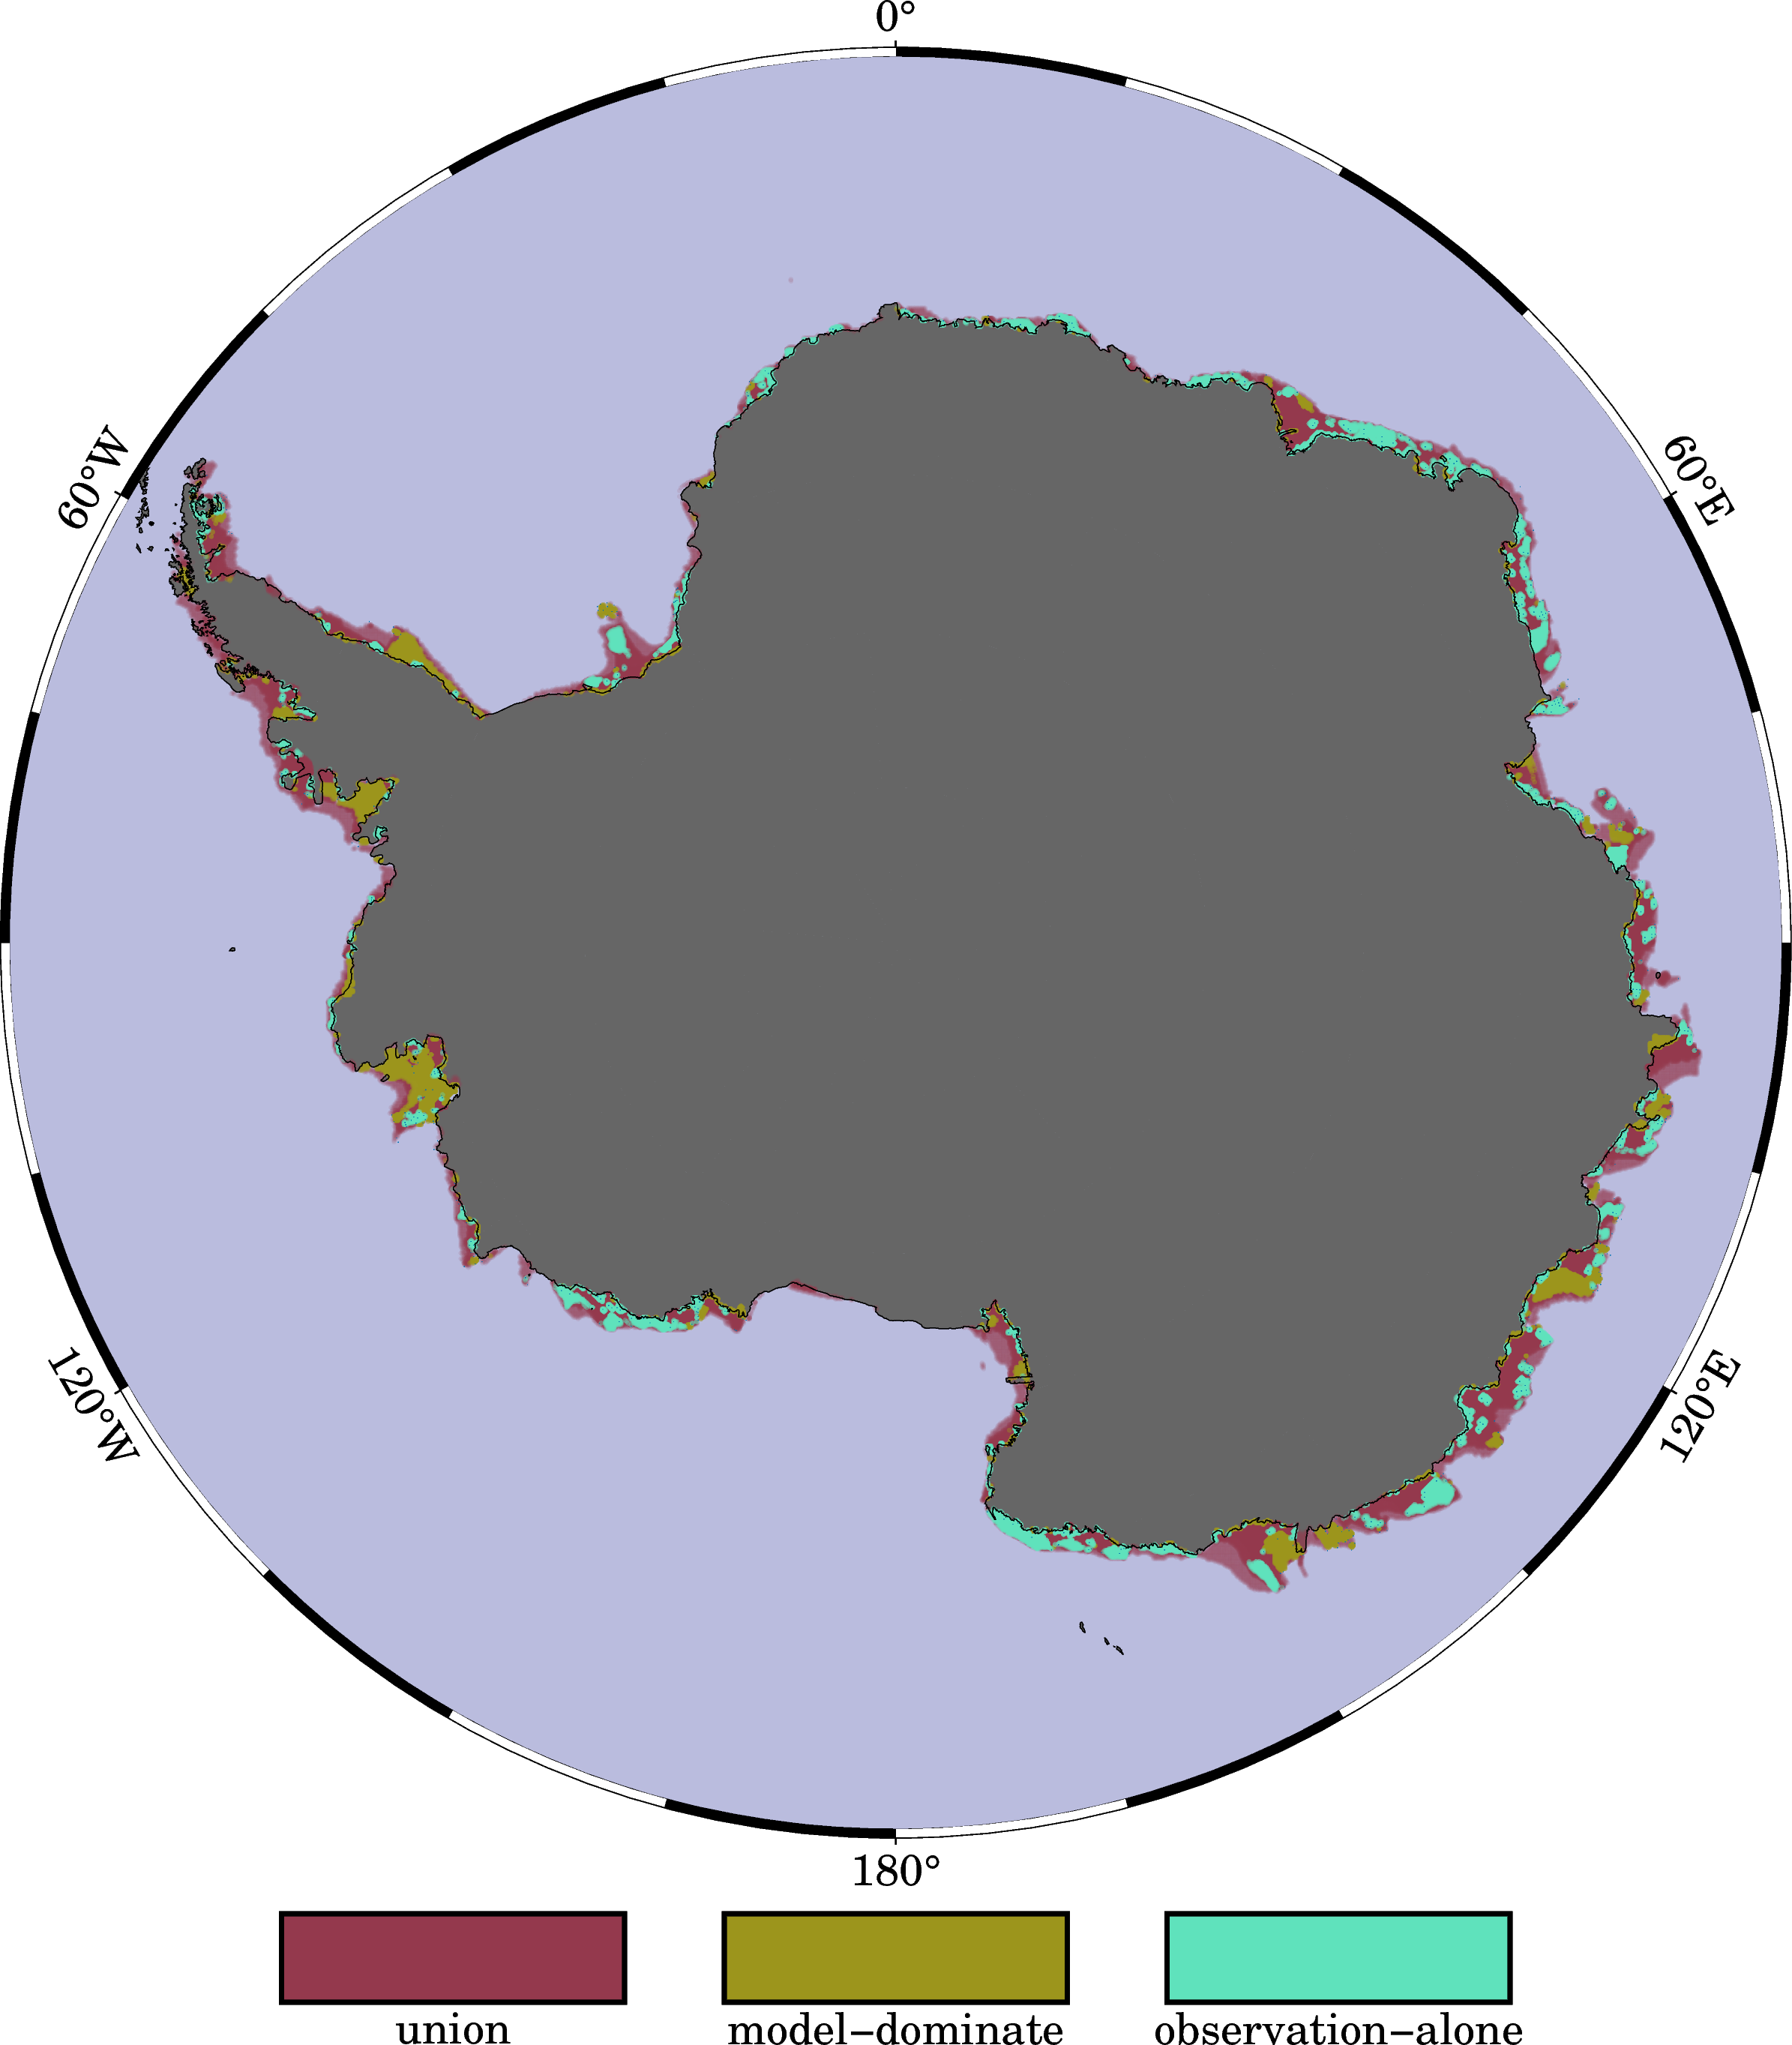

In [28]:
fig = pygmt_FIP_figure(FIP['diff_cat'],
                       var_name      = "diff_cat",
                       weight_da     = w,
                       region        = region,
                       cmap          = cmap,
                       series        = [-1,1],
                       G_pt_size     = G_pt_size,
                       cbar_frame    = ["xa0.2f0.1+lFast Ice Persistence Difference (mod-obs)"],
                       P_png         = P_diff,
                       show_fig      = True,
                       plot_GI       = True,
                       GI_color      = "#0072B2",
                       cat_series    = (0,1,2),
                       basemap_frame = frame_diff,
                       cat_labels    = ["union", "model-dominate", "observation-alone"])

2025-08-28 14:31:37,620 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:37,622 - INFO - Hemisphere slice applied on dims: nj & nj_b.


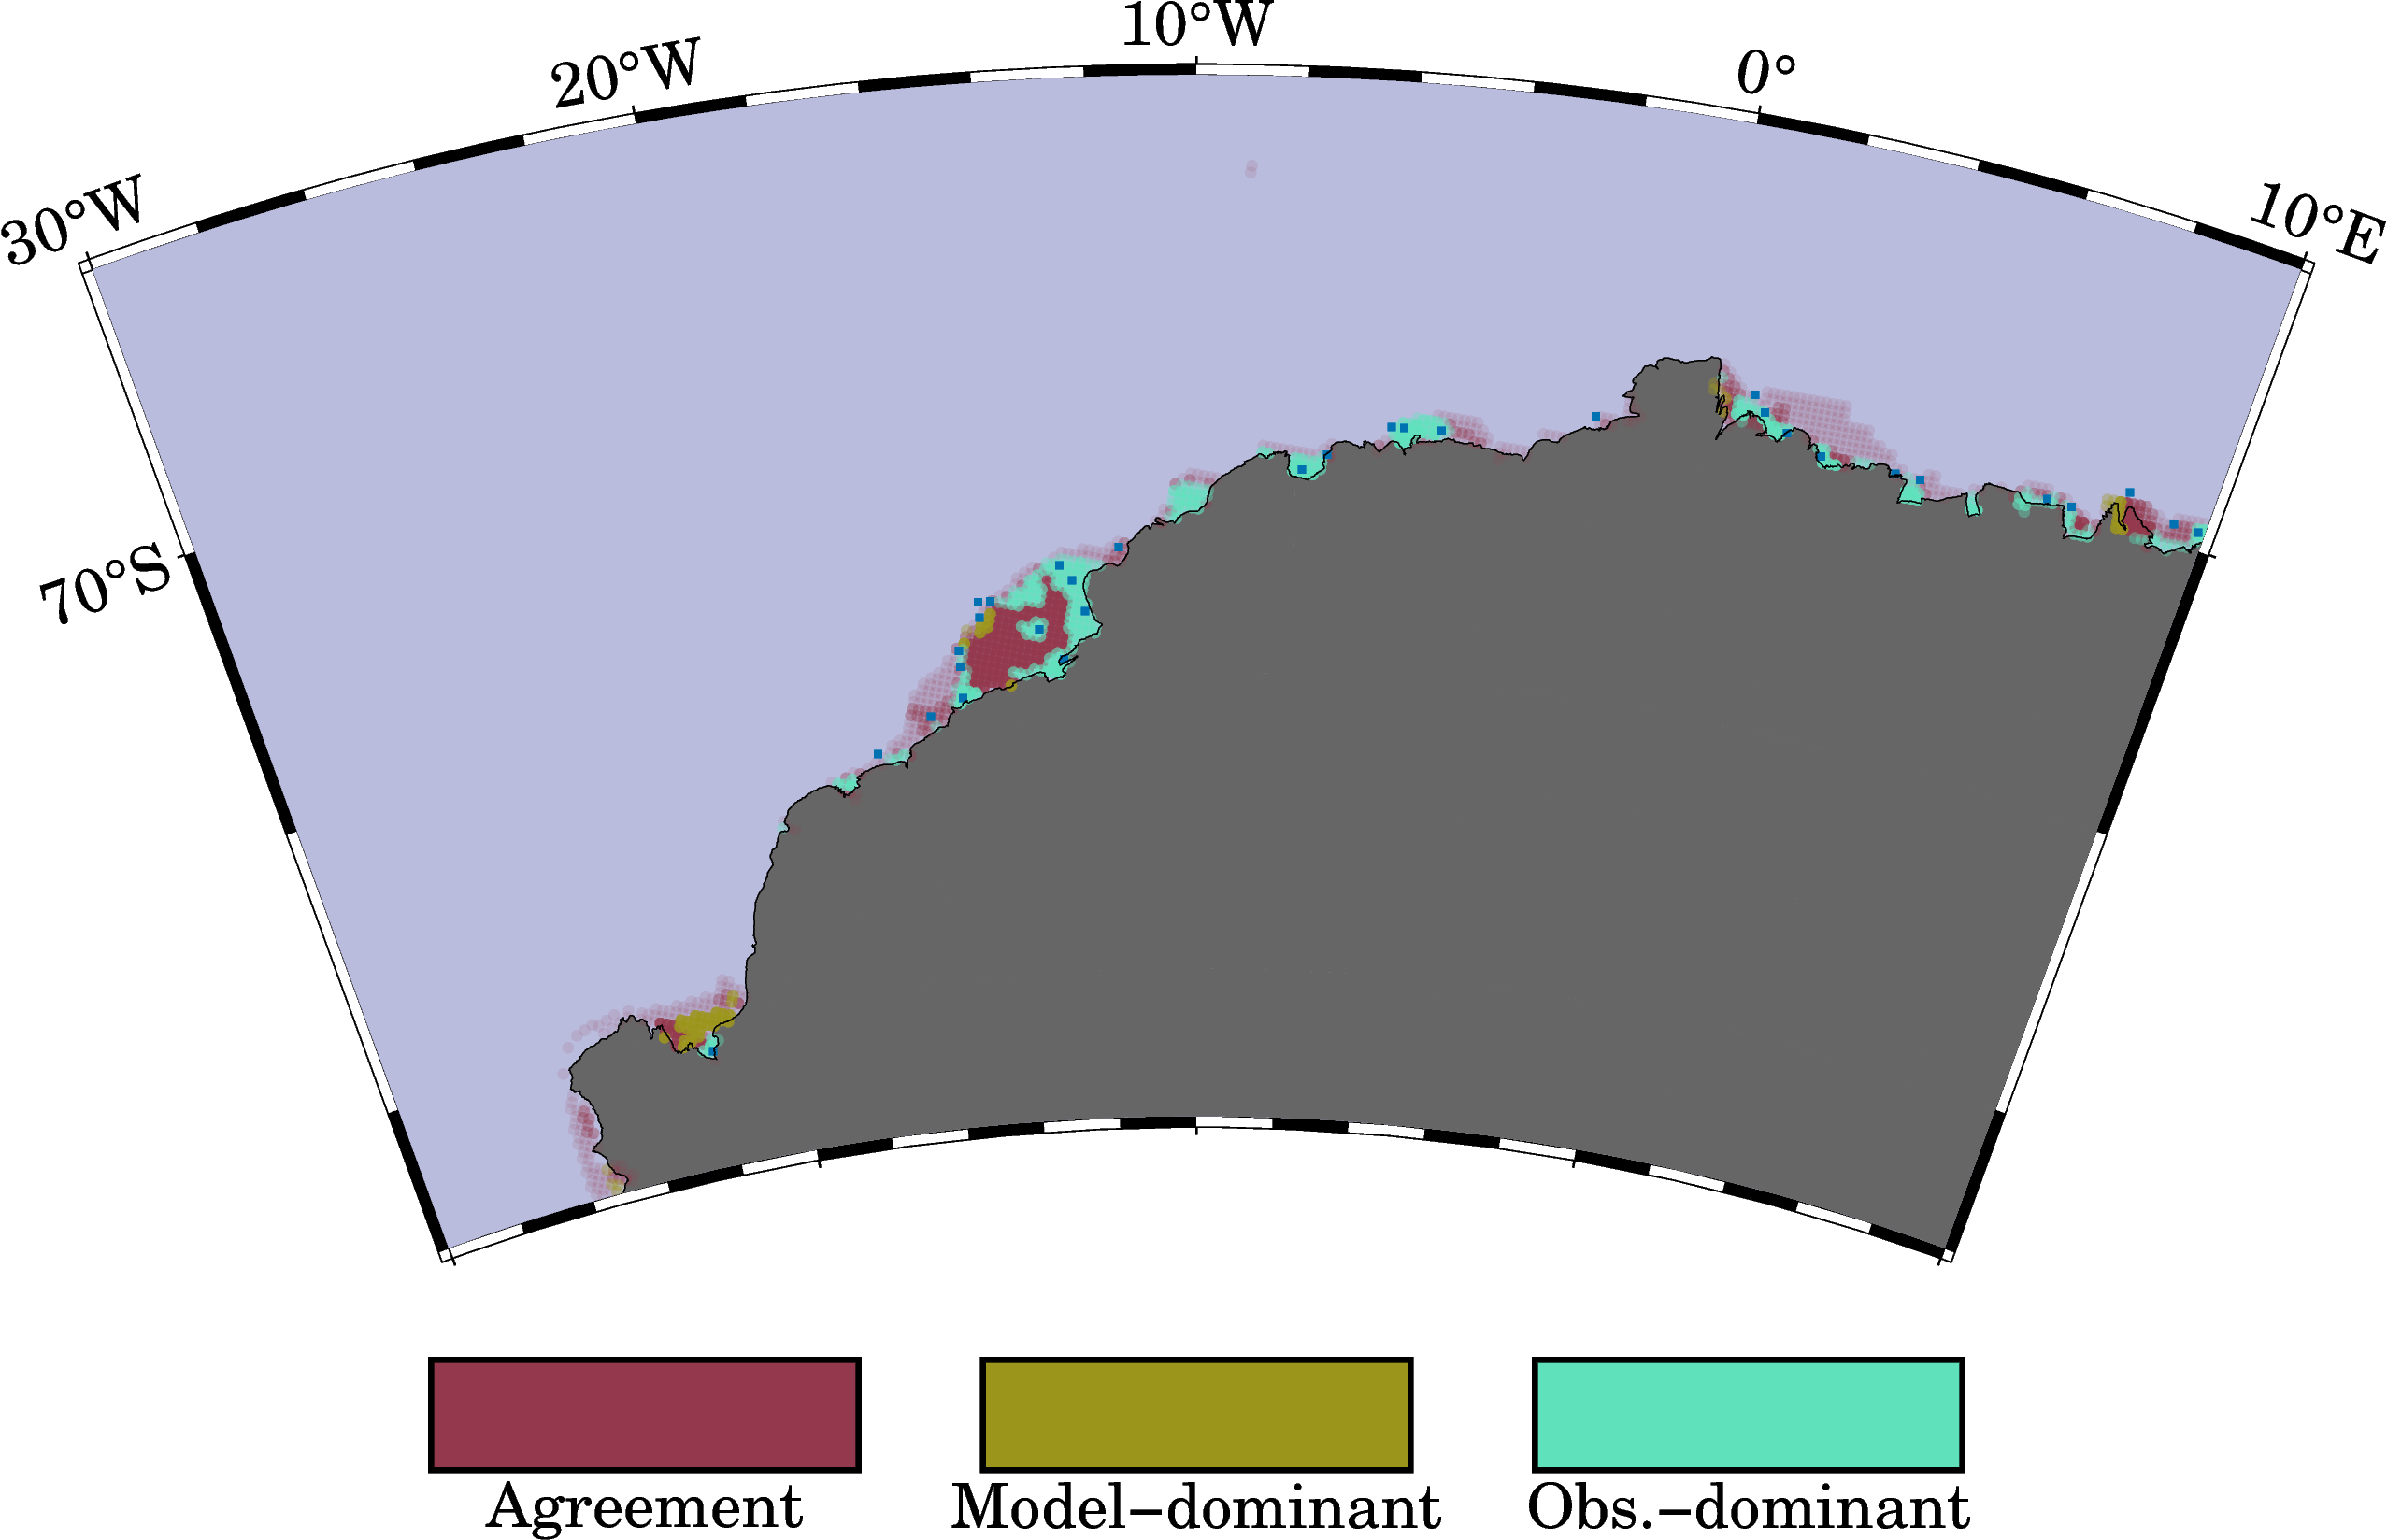

2025-08-28 14:31:40,213 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:40,215 - INFO - Hemisphere slice applied on dims: nj & nj_b.


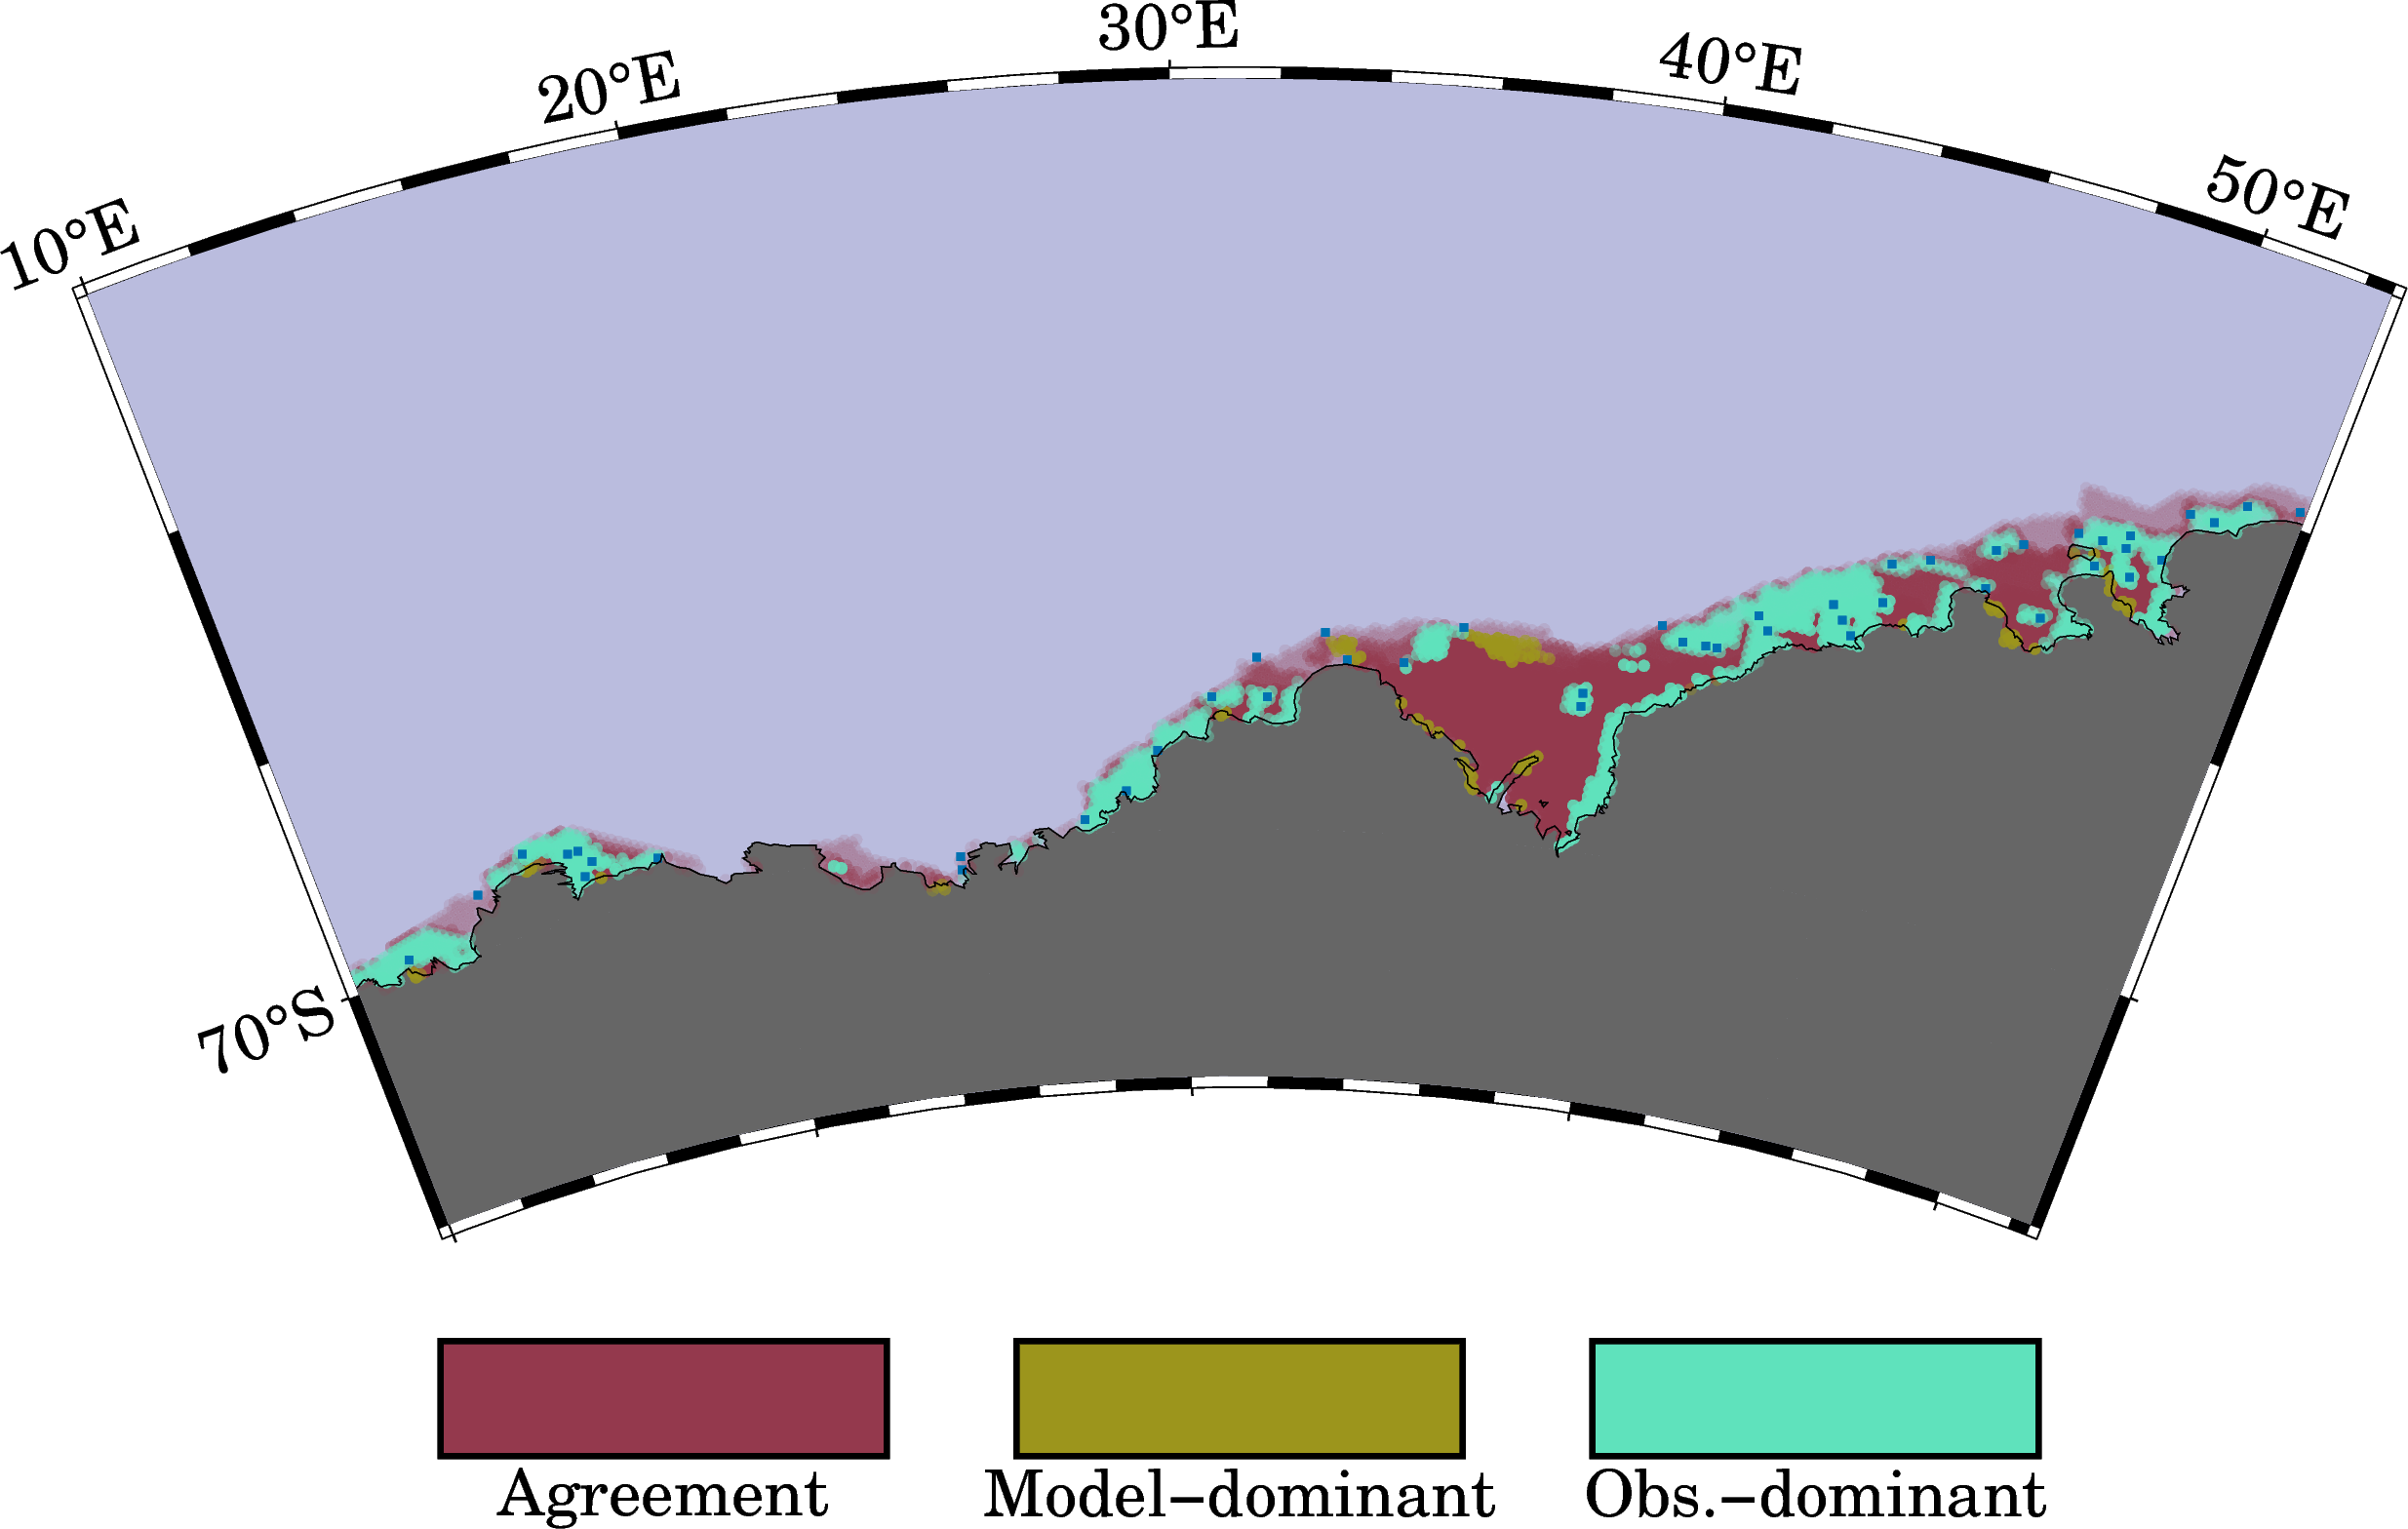

2025-08-28 14:31:43,002 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:43,004 - INFO - Hemisphere slice applied on dims: nj & nj_b.


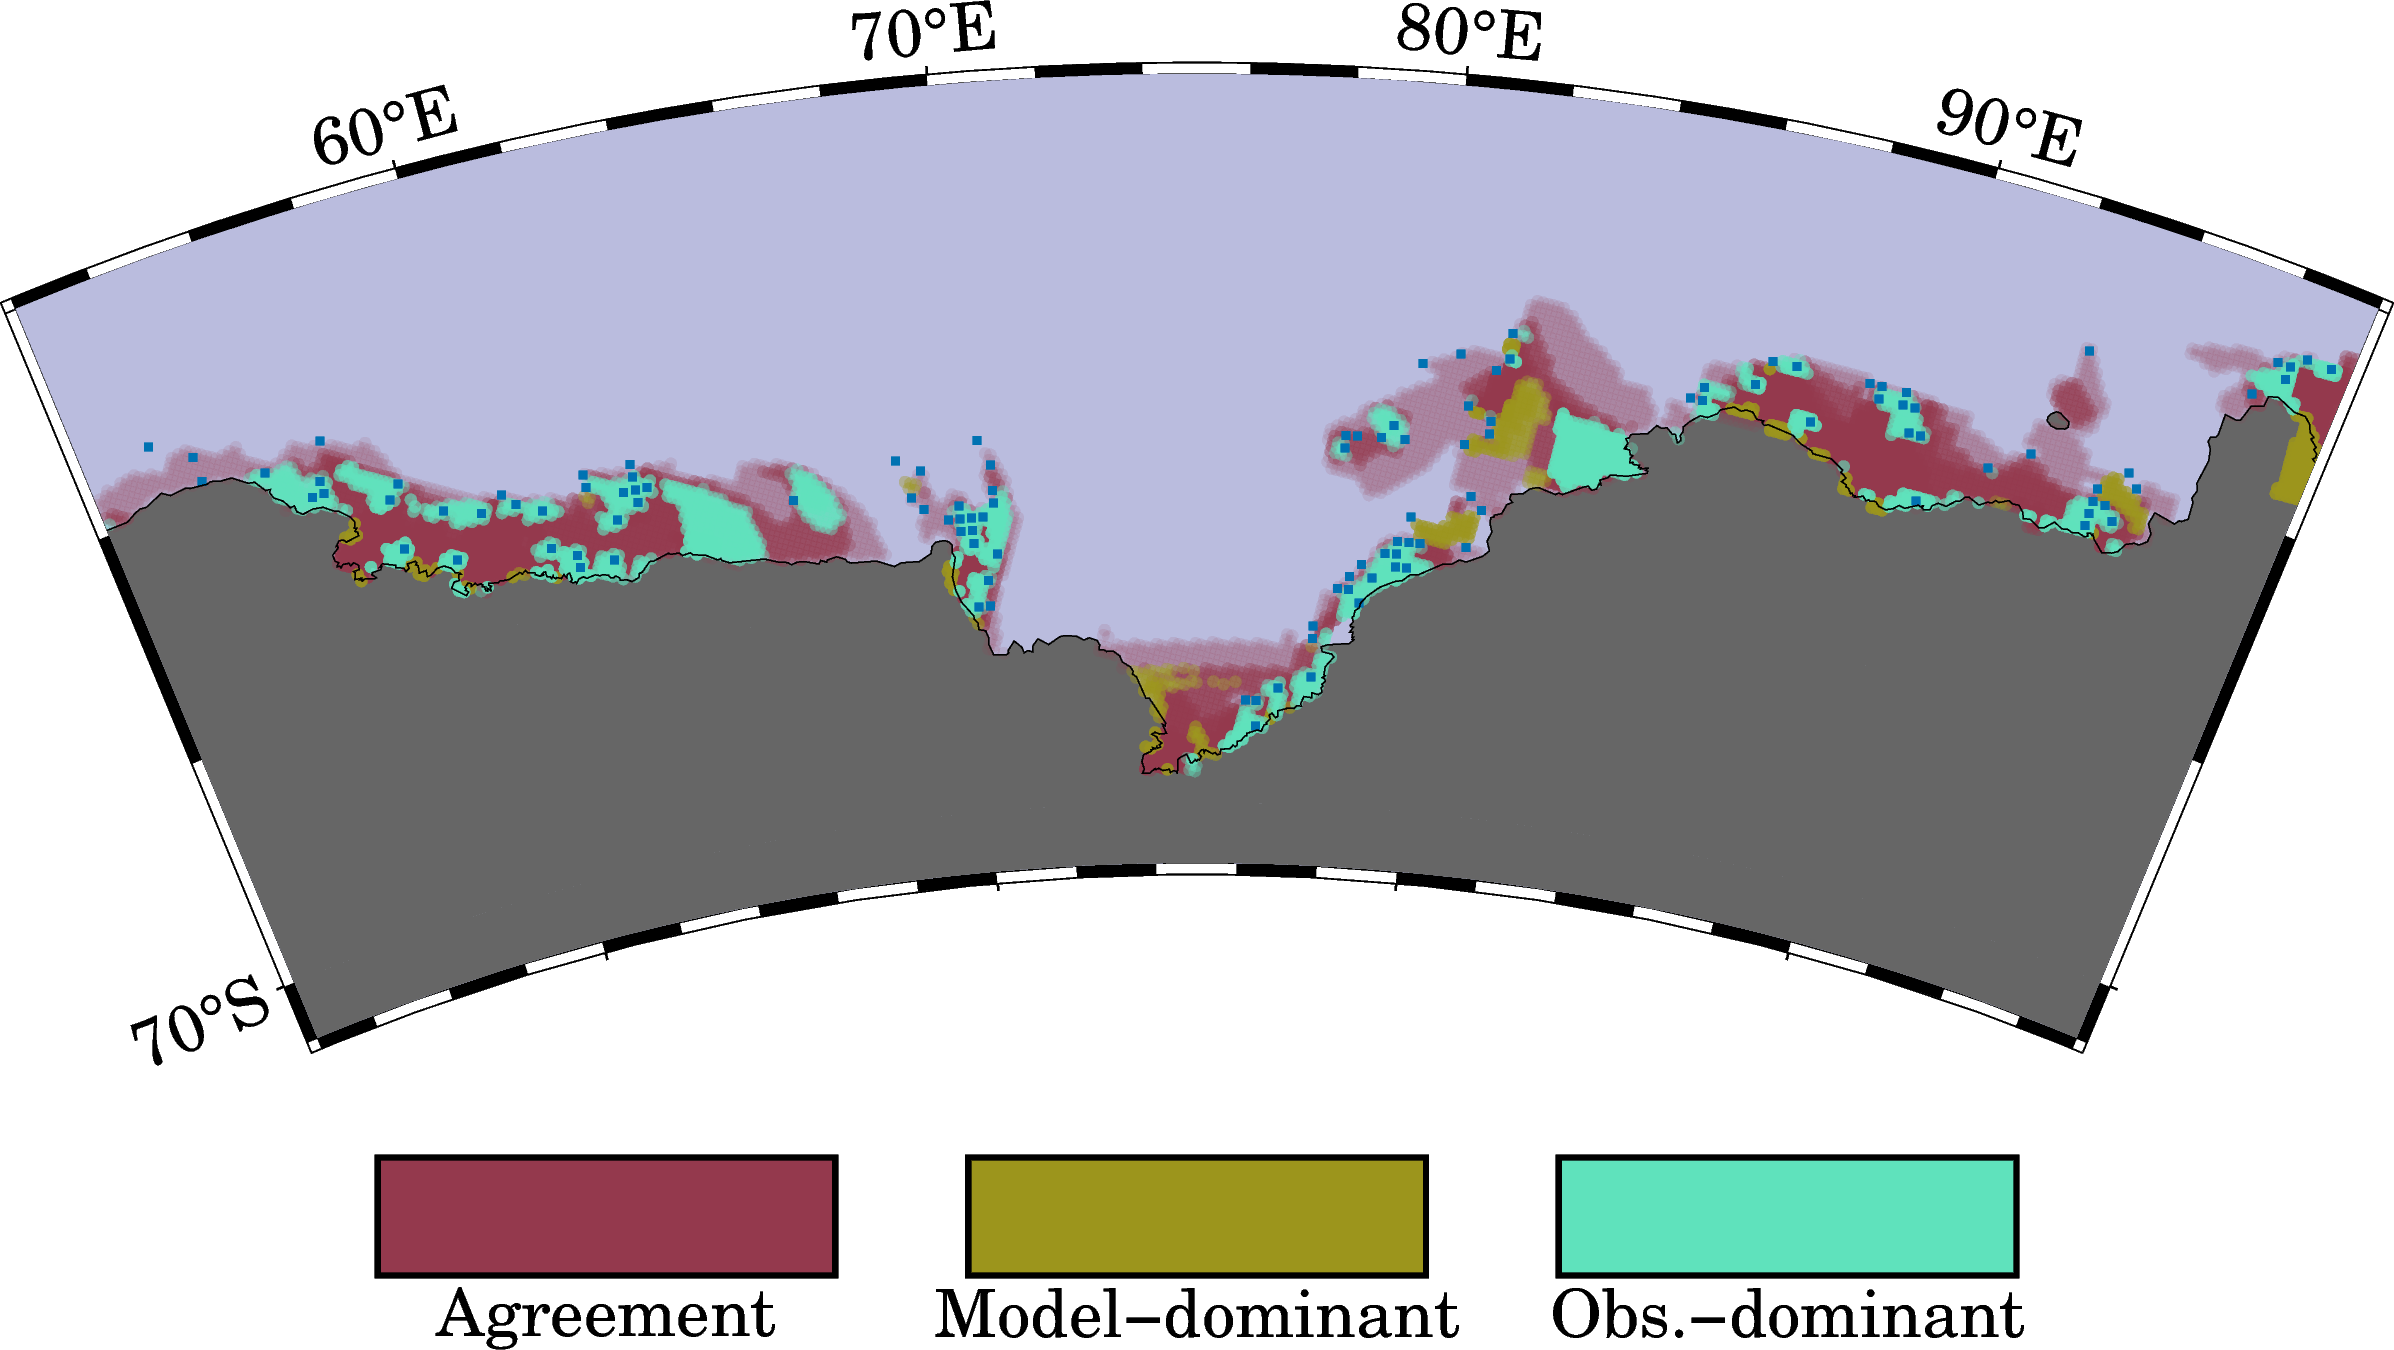

2025-08-28 14:31:46,136 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:46,139 - INFO - Hemisphere slice applied on dims: nj & nj_b.


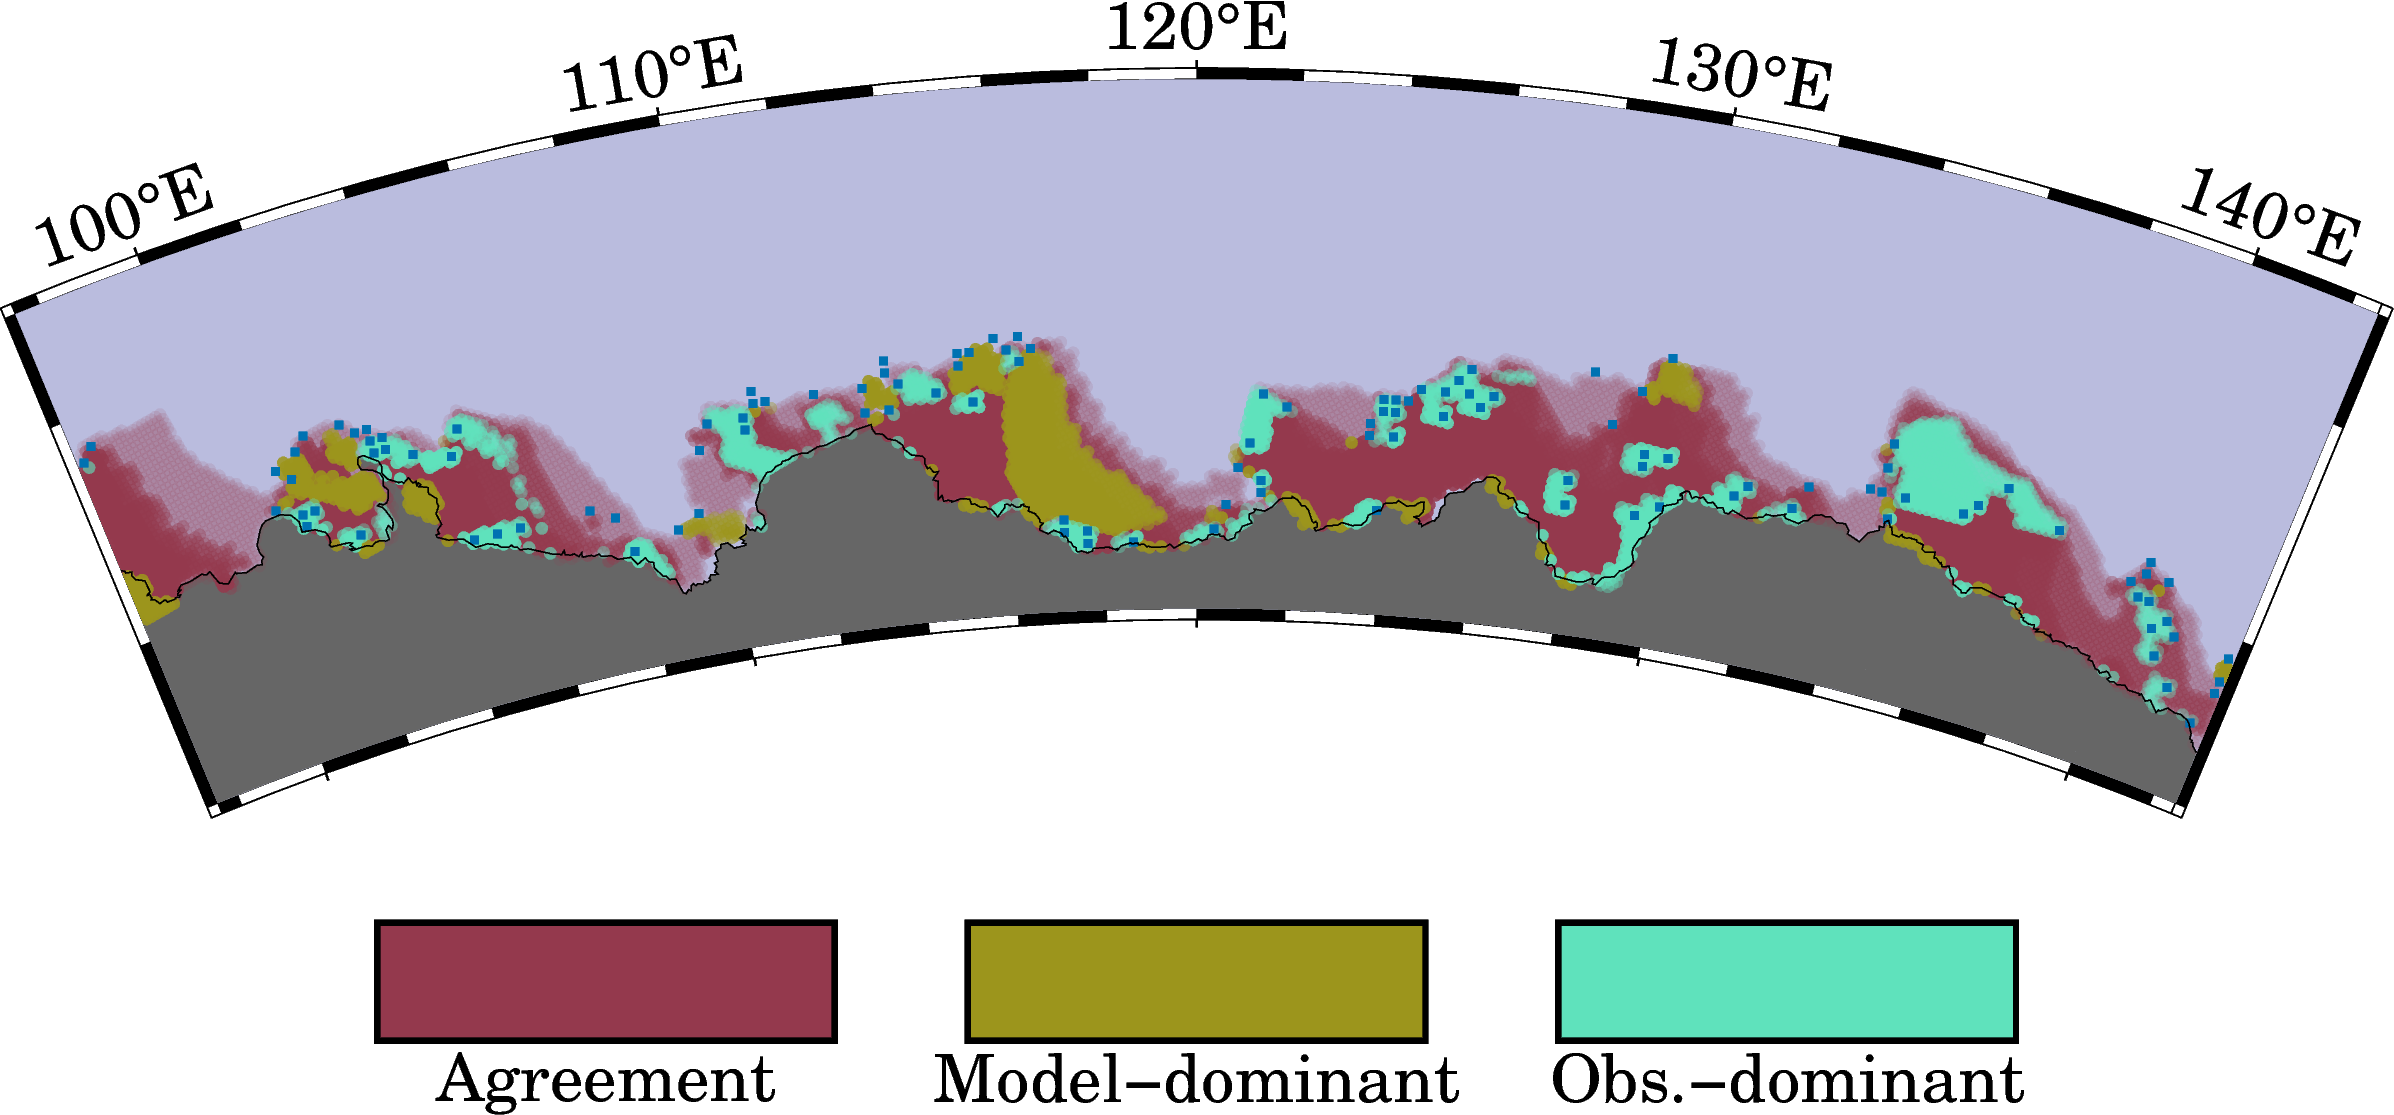

2025-08-28 14:31:49,593 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:49,594 - INFO - Hemisphere slice applied on dims: nj & nj_b.


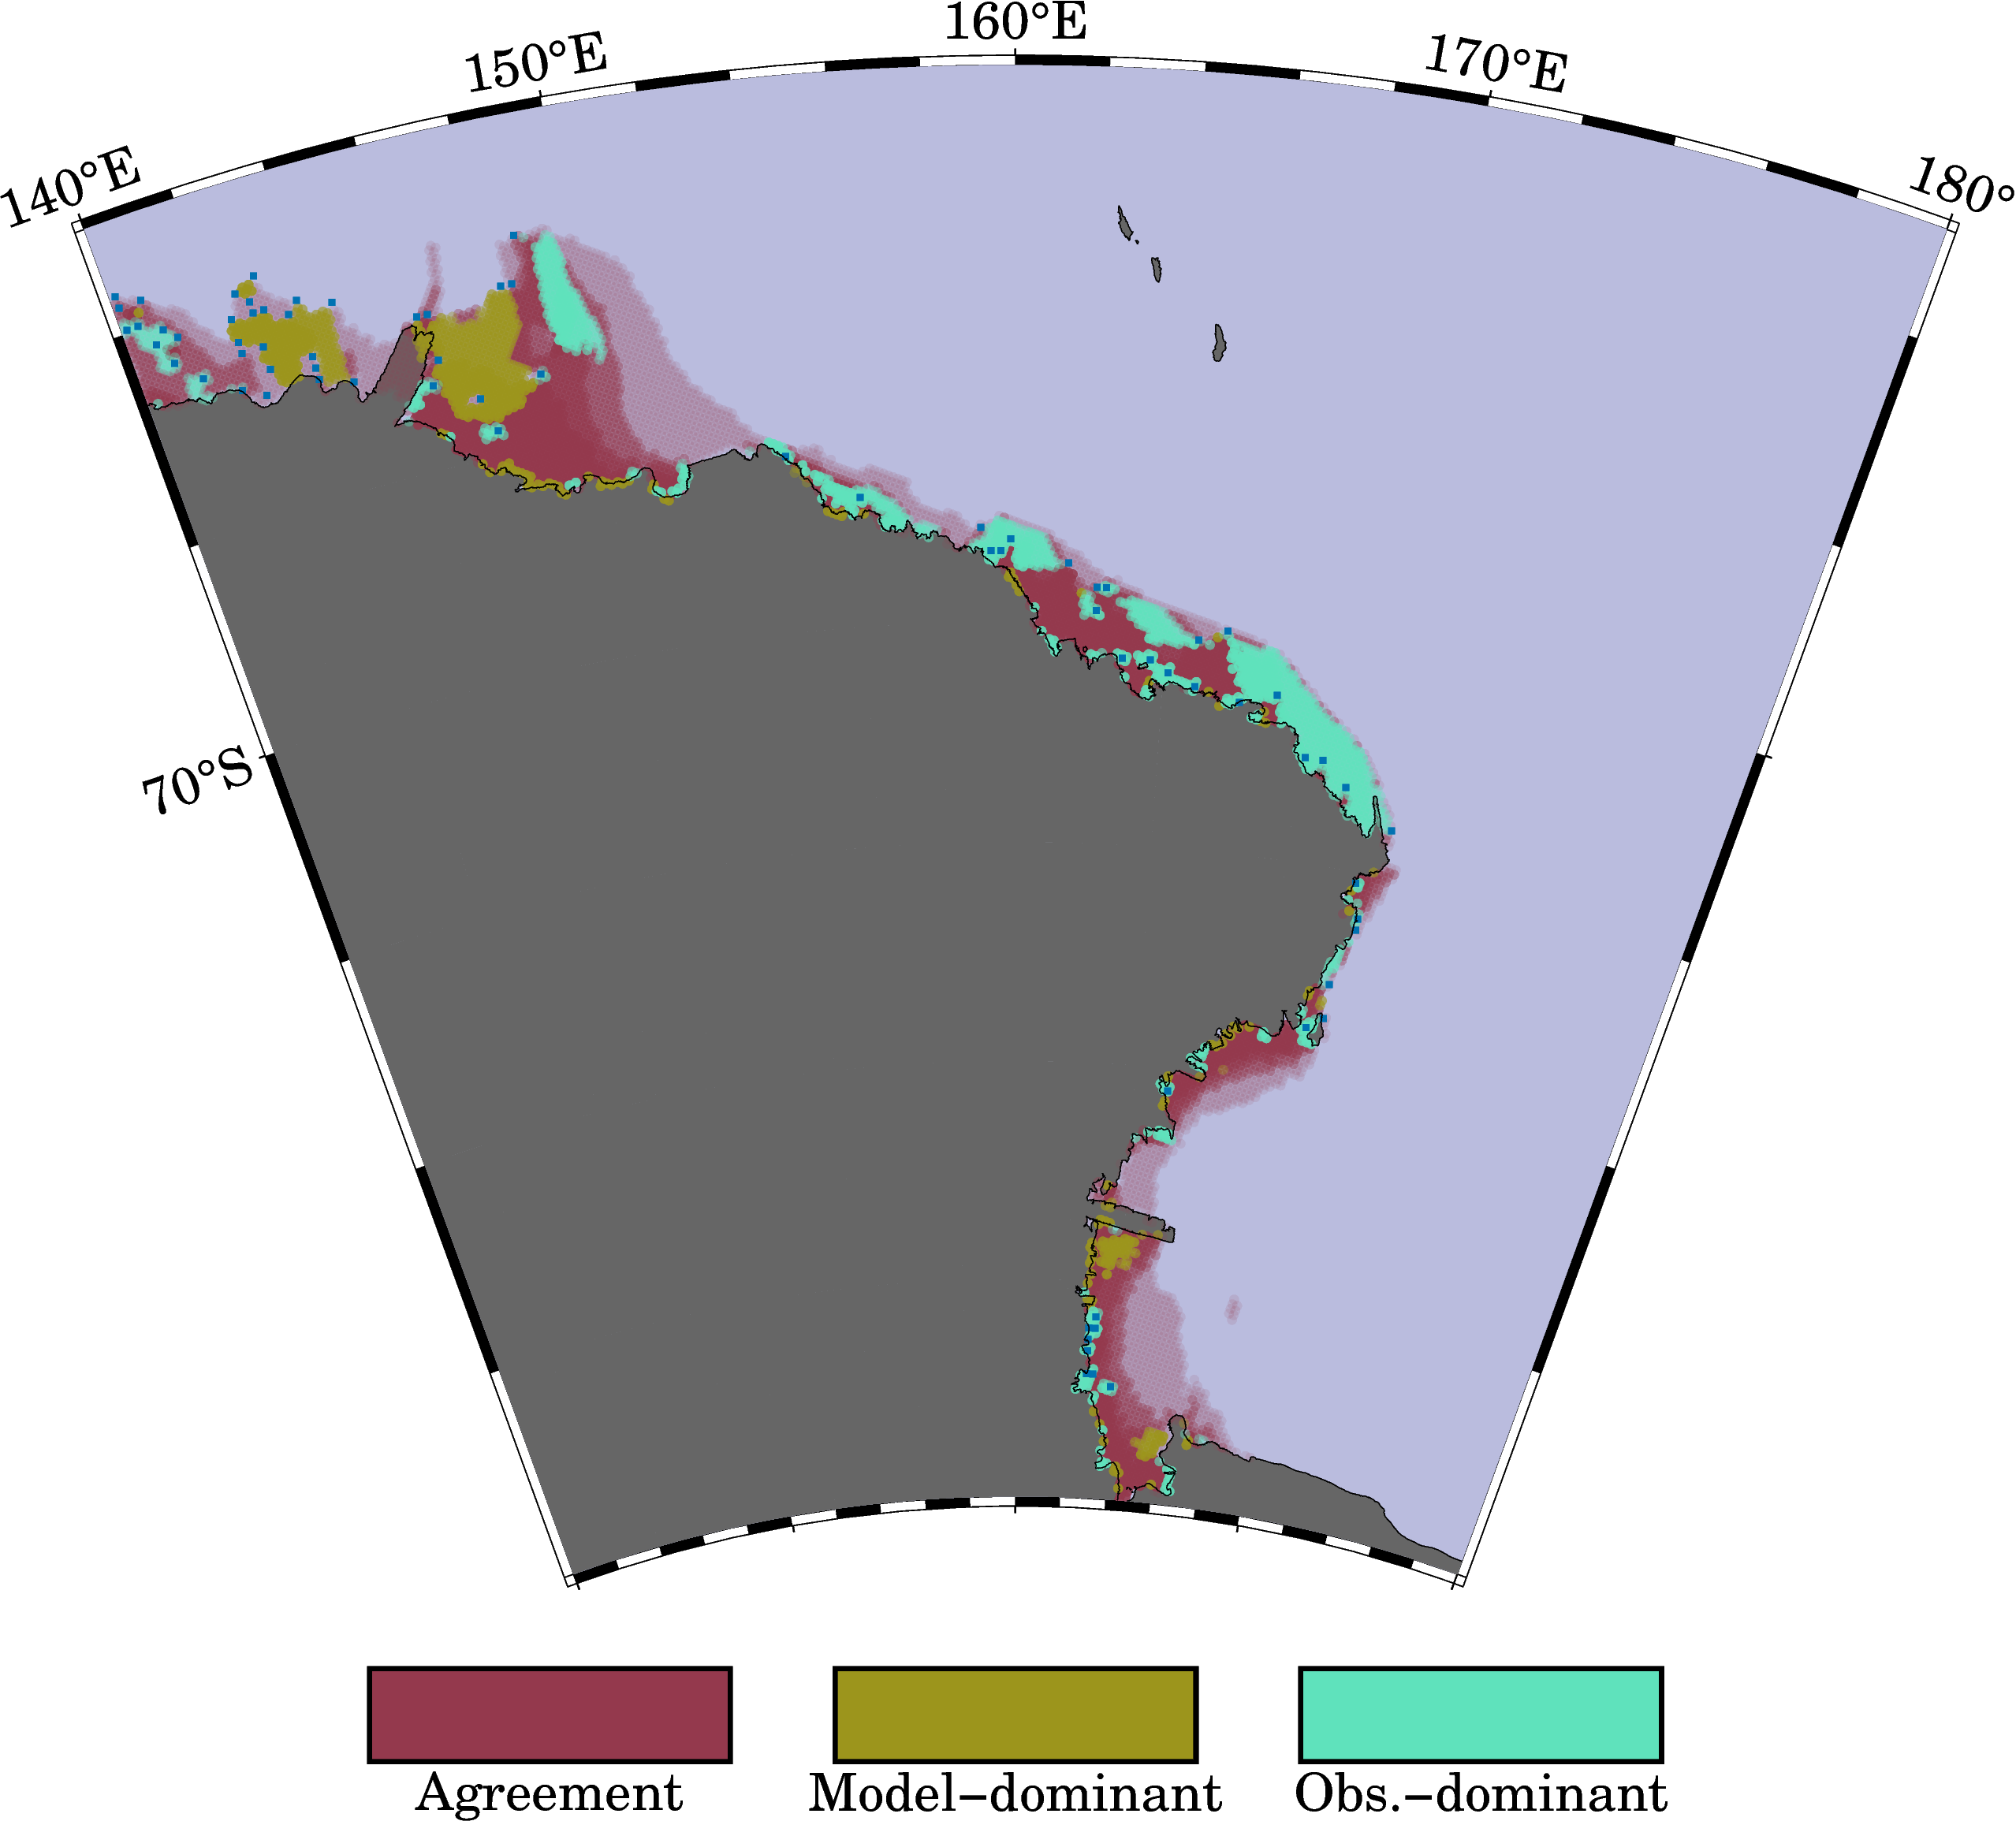

2025-08-28 14:31:53,350 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:53,352 - INFO - Hemisphere slice applied on dims: nj & nj_b.


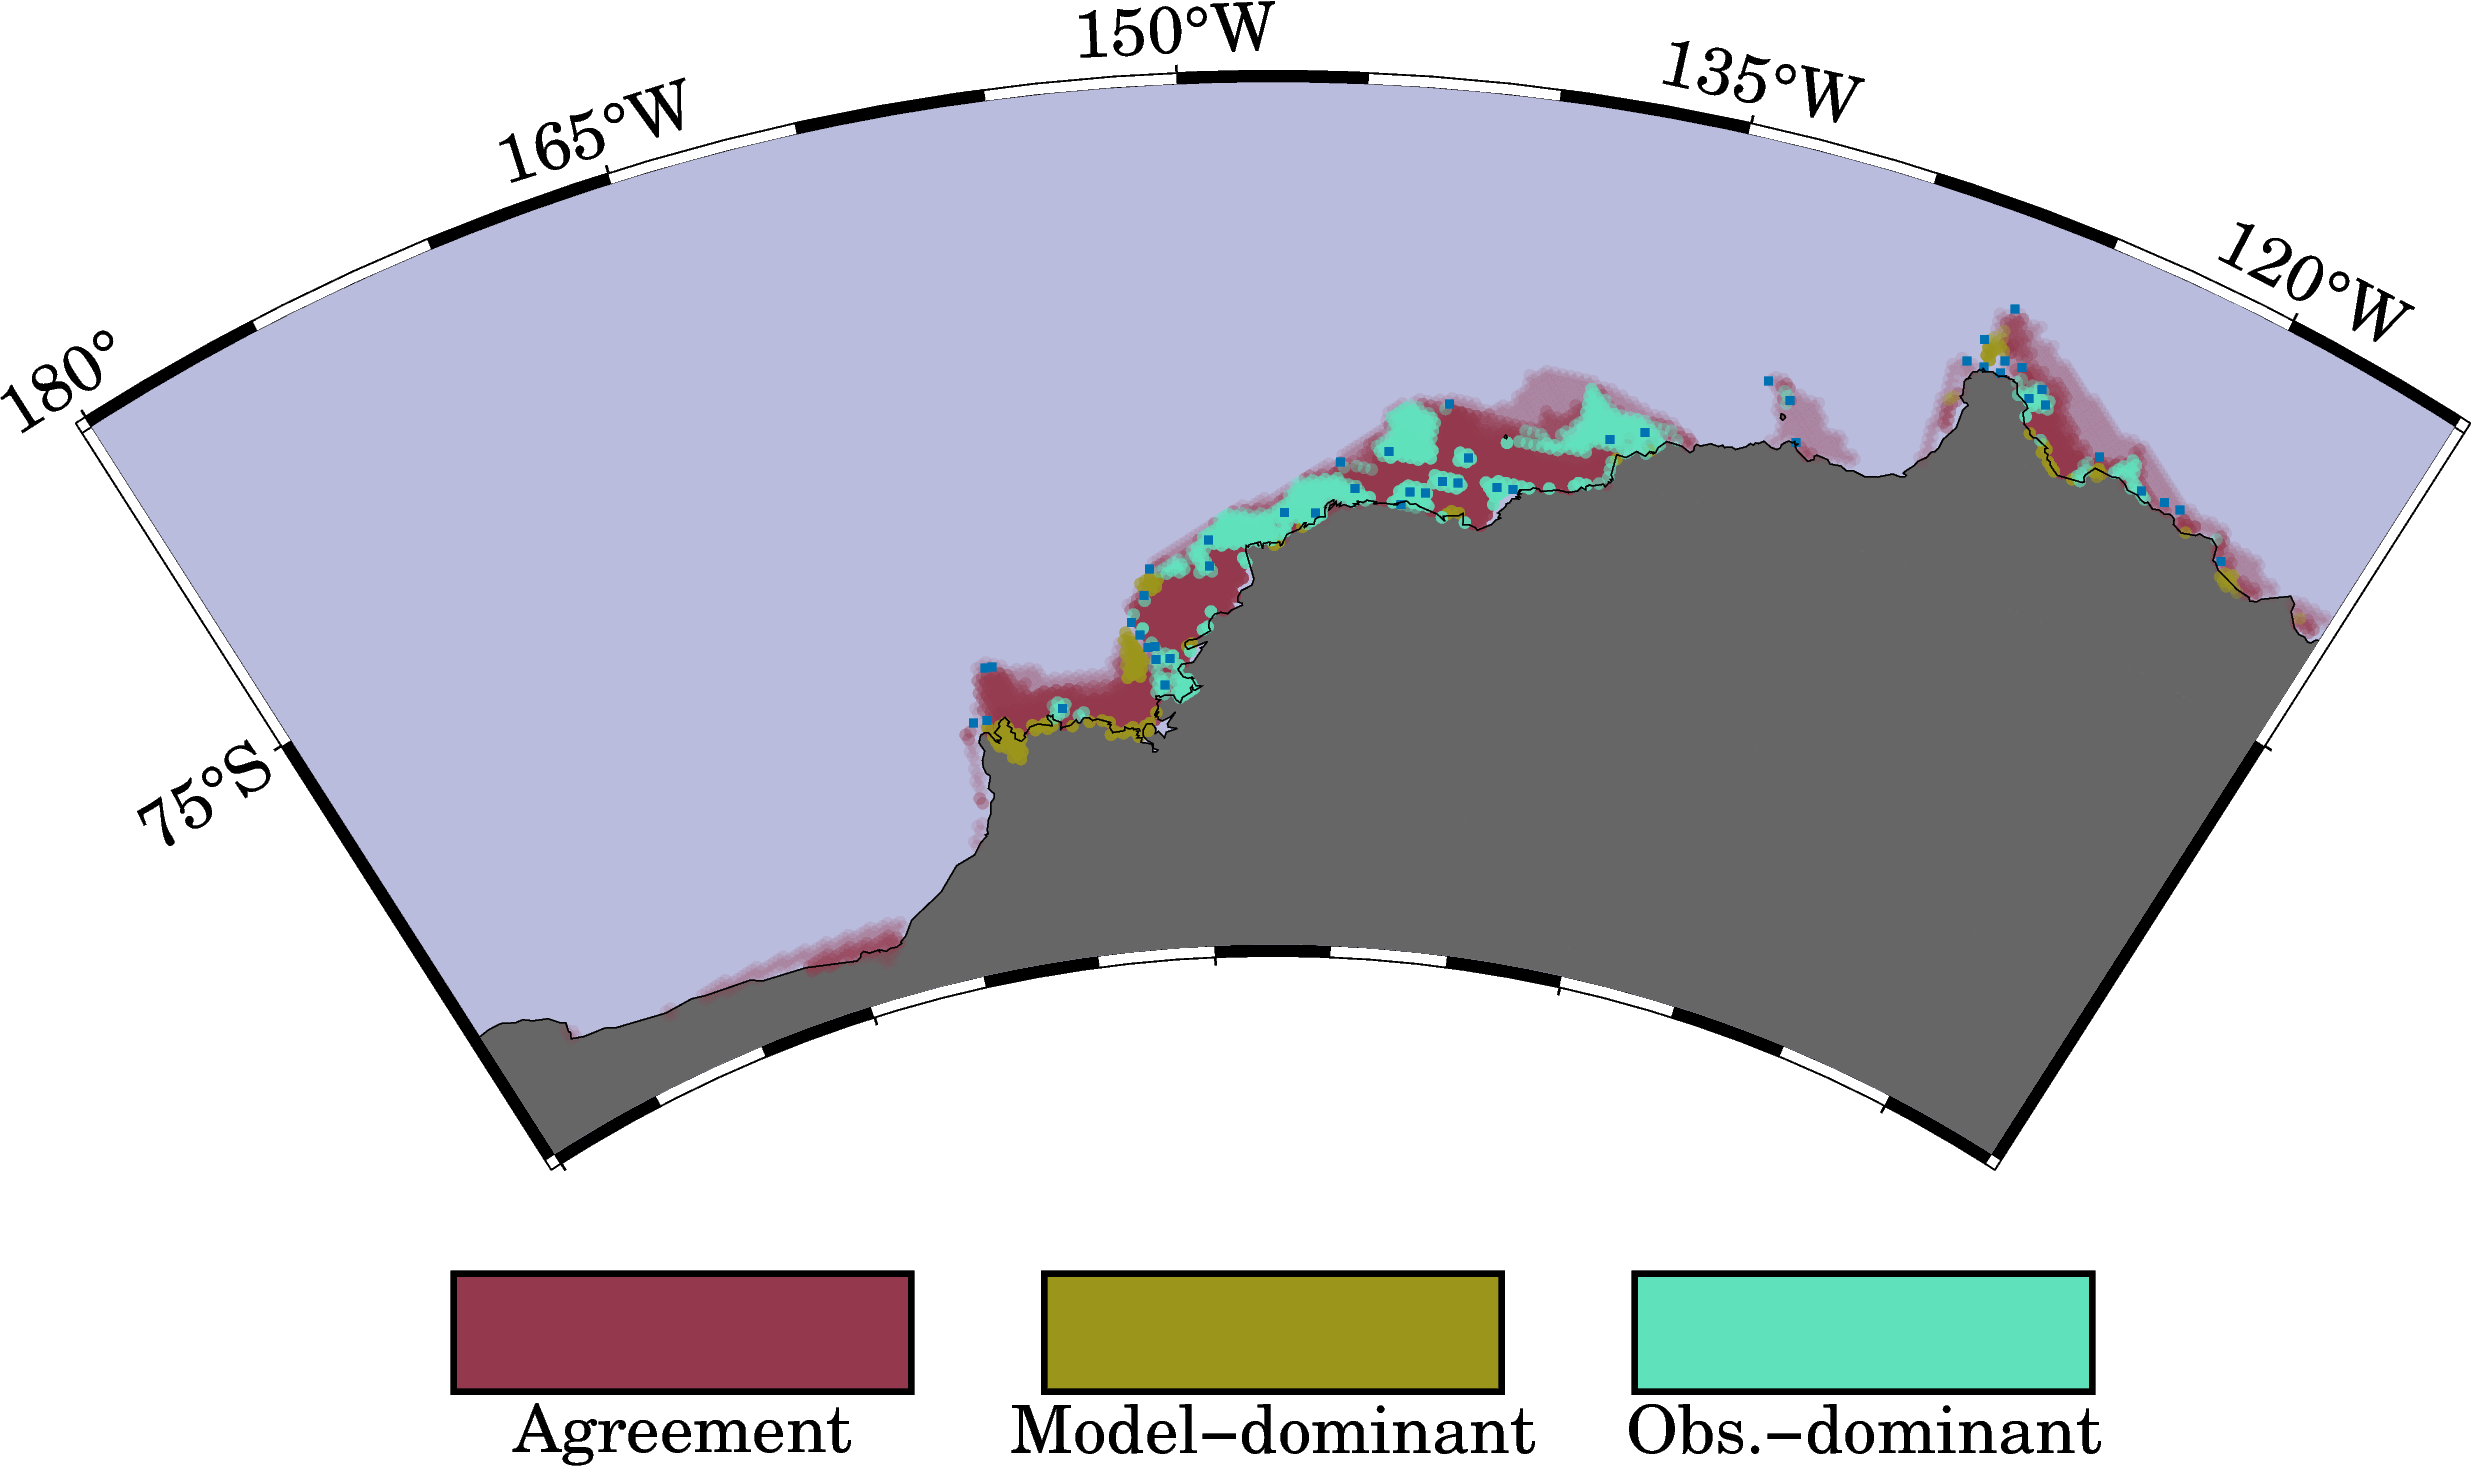

2025-08-28 14:31:56,108 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:56,109 - INFO - Hemisphere slice applied on dims: nj & nj_b.


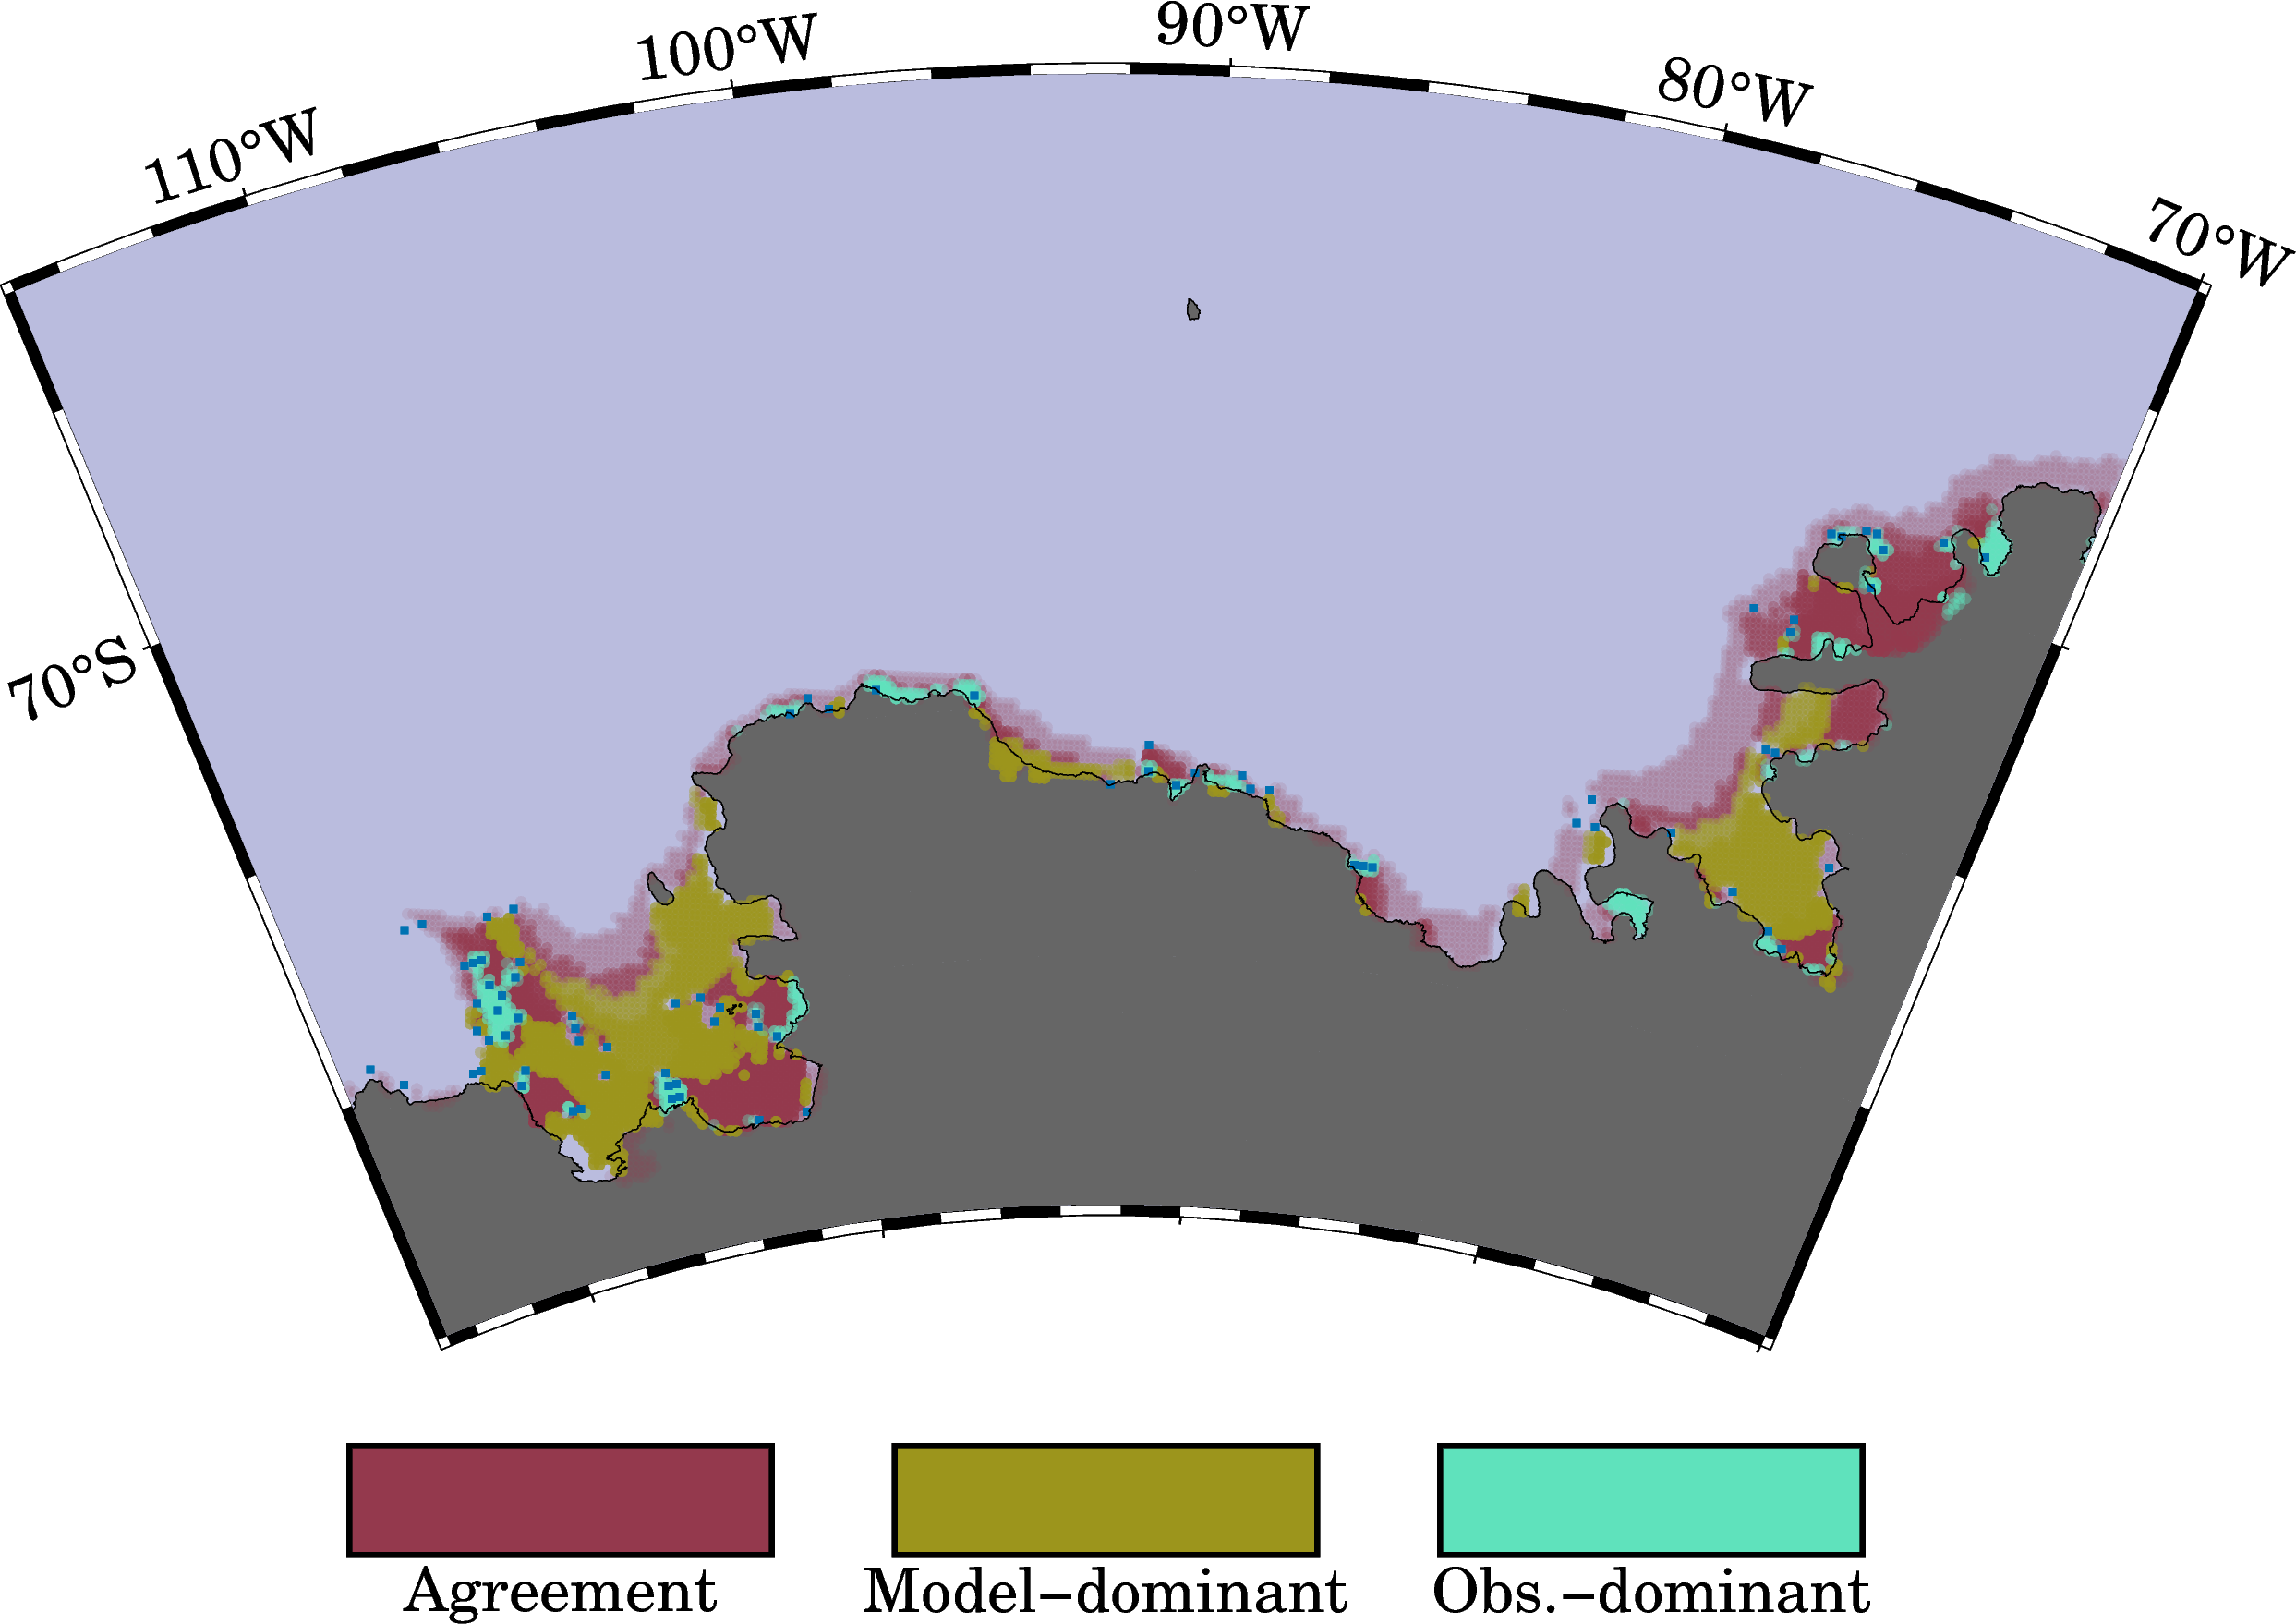

2025-08-28 14:31:59,409 - INFO - Hemisphere slice applied on dims: nj & nj_b.
2025-08-28 14:31:59,411 - INFO - Hemisphere slice applied on dims: nj & nj_b.


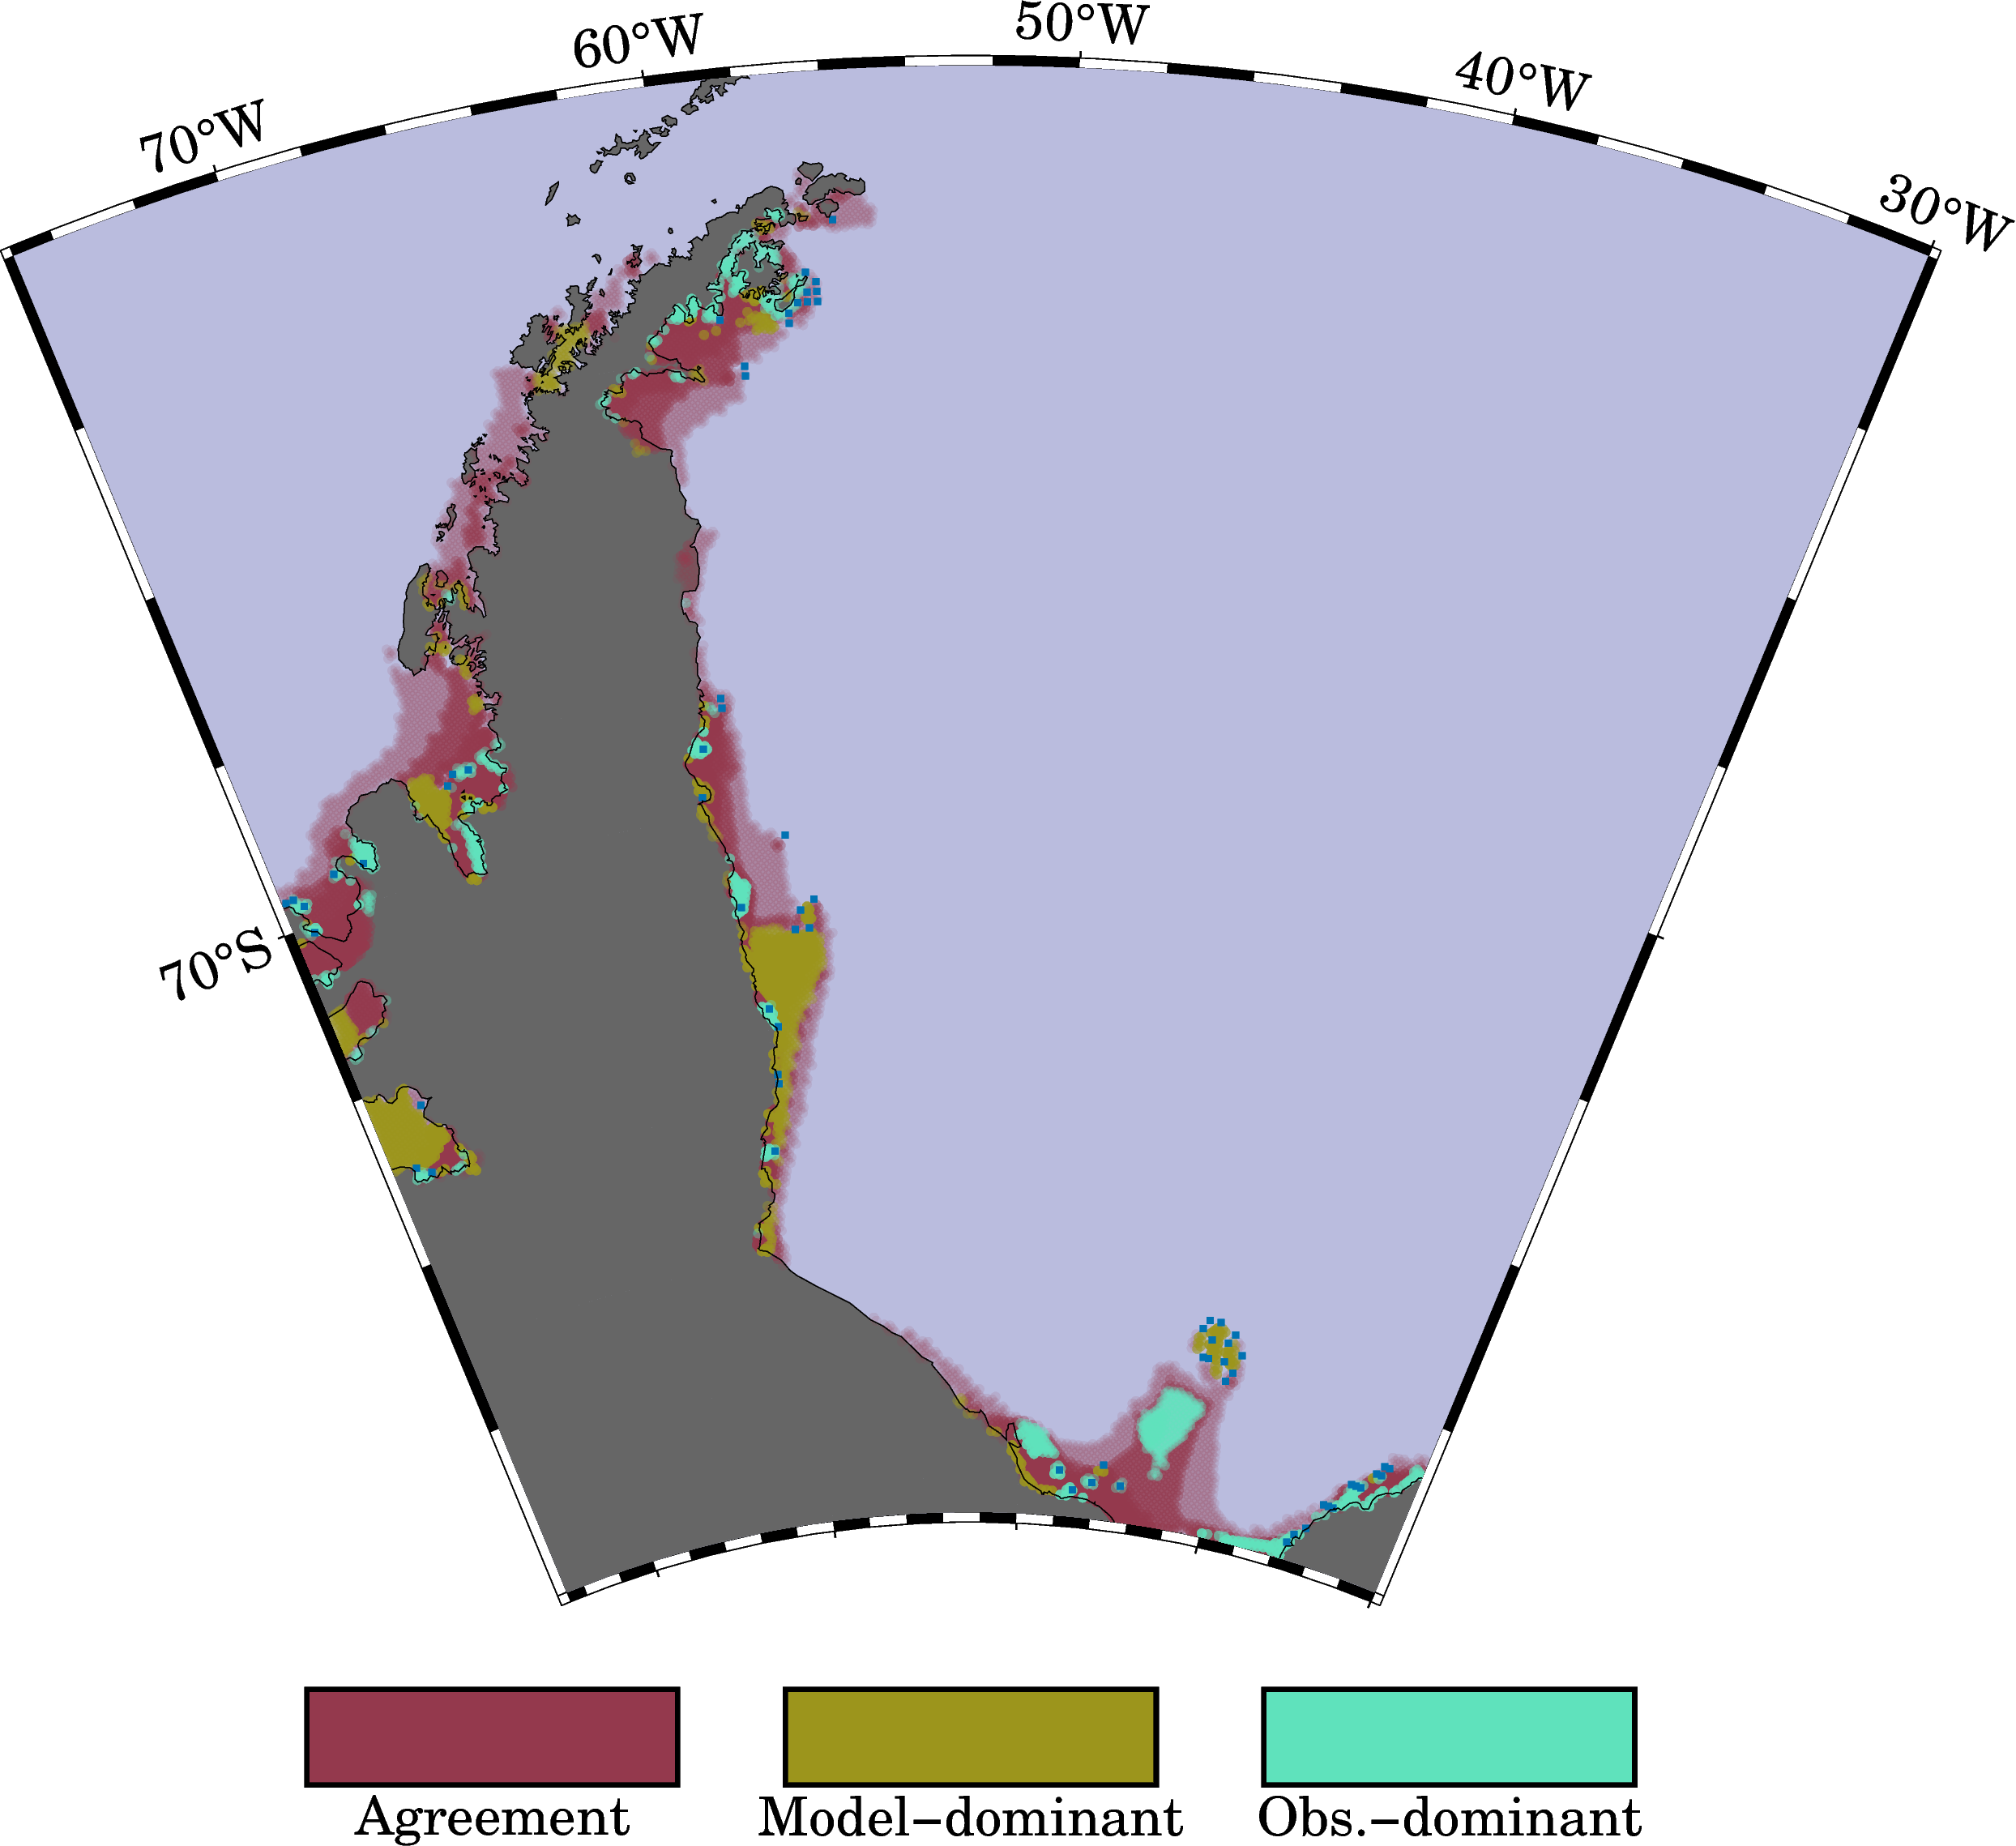

In [31]:
for i, (reg_name, reg_vals) in enumerate(SI_tools.Ant_8sectors.items()):
    #P_png      = SI_tools.D_graph / sim_name / reg_name / "FIP" / f"FIP_{sim_name}_org-shift_2000-2018_{reg_name}.png"
    #P_png      = SI_tools.D_graph / "AF20" / reg_name / "FIP" / f"FIP_AF2020_reG_2000-2018_{reg_name}.png"
    P_png      = SI_tools.D_graph / sim_name / reg_name / "FIP" / f"FIP-diff-cat_{sim_name}-AF2020_2000-2018_{reg_name}.png"
    region     = reg_vals['plot_region']
    projection = reg_vals['projection']
    MC         = SI_tools.get_meridian_center_from_geographic_extent(region)
    projection = projection.format(MC=MC, fig_size=fig_size)
    fig = pygmt_FIP_figure(FIP['diff_cat'],
                           var_name      = "diff_cat",
                           weight_da     = w,
                           region        = region,
                           projection    = projection,
                           G_pt_size     = "0.1",
                           #G_pt_marker   = G_pt_marker,
                           P_png         = P_png,
                           show_fig      = True,
                           plot_GI       = True,
                           GI_color      = "#0072B2",
                           GI_size       = "0.1",
                           cat_series    = (0,1,2),
                           basemap_frame = frame_diff,
                           plot_bathymetry = False,
                           cat_labels    = ["Agreement", "Model-dominant", "Obs.-dominant"])

In [ ]:
mod, obs  = xr.align(DS['mod'], DS['obs'], join="exact")
tol       = 1e-8  # treat tiny values as zero
both_zero = np.isclose(mod, 0.0, atol=tol) & np.isclose(obs, 0.0, atol=tol)m # mask out places where both were zero (or ~zero) BEFORE differencing
diff      = (mod - obs)
diff      = diff.where(~both_zero)
diff      = diff.where(np.isfinite(diff))
diff      = diff.clip(min=-1.0, max=1.0) 

In [ ]:
x1D  = diff['lon'].values.flatten()
y1D  = diff['lat'].values.flatten()
z1D  = diff.values.flatten()
mask = np.isfinite(z1D)
x    = x1D[mask]
y    = y1D[mask]
z    = z1D[mask]
plot_data = np.column_stack([x, y, z])

In [ ]:
cmap      = "cmocean/curl"
G_pt_size = "0.05"
fig_size  = 20
region    = [0,360,-90,-62]
P_obs     = SI_tools.D_graph / "AF20" / "FIP_AF2020_reG_2000-2018.png"
P_mod     = SI_tools.D_graph / sim_name / f"FIP_{sim_name}_reG_2000-2018.png"
P_diff    = SI_tools.D_graph / sim_name / f"FIP-diff_{sim_name}-AF2020_2000-2018.png"
frame_obs = ["af",f"+tAF2020-reG 2000-2018"]
frame_mod = ["af",f"+t{sim_name}-reG 2000-2018"]
frame_diff = ["af",f"+t{sim_name}-AF2020 2000-2018"]
#plot_data = pygmt_data_prep( DS['obs'] )
pygmt_FIP_figure(plot_data,
                 region        = region,
                 cmap          = cmap,
                 series        = [-1,1],
                 G_pt_size     = G_pt_size,
                 cbar_frame    = ["xa0.2f0.1+lFast Ice Persistence Difference (mod-obs)"],
                 P_png         = P_diff,
                 show_fig      = True,
                 basemap_frame = frame_diff)

In [ ]:
FIP_obs_reG = define_fast_ice_persistence_da(FIP_obs_reG, reG=True)
FIP_mod_reG = define_fast_ice_persistence_da(FIP_mod_reG, reG=True)

In [ ]:
G_pt_size = "0.05"
fig_size  = 20
for i, (reg_name, reg_vals) in enumerate(SI_tools.Ant_8sectors.items()):
    #P_png      = SI_tools.D_graph / sim_name / reg_name / "FIP" / f"FIP_{sim_name}_reG_2000-2018_{reg_name}.png"
    #P_png      = SI_tools.D_graph / "AF20" / reg_name / "FIP" / f"FIP_AF2020_reG_2000-2018_{reg_name}.png"
    P_png      = SI_tools.D_graph / sim_name / reg_name / "FIP" / f"FIP-diff_{sim_name}-AF2020_2000-2018_{reg_name}.png"
    region     = reg_vals['plot_region']
    projection = reg_vals['projection']
    MC         = SI_tools.get_meridian_center_from_geographic_extent(region)
    projection = projection.format(MC=MC, fig_size=fig_size)
    pygmt_FIP_figure(plot_data,
                     region        = region,
                     projection    = projection,
                     cmap          = cmap,
                     series        = [-1,1],
                     G_pt_size     = G_pt_size,
                     cbar_frame    = ["xa0.2f0.1+lFast Ice Persistence Difference (mod-obs)"],
                     P_png         = P_png,
                     show_fig      = True,
                     basemap_frame = frame_diff,
                     plot_bathymetry = True)

In [ ]:
#region    = [-180,180,-90,-62]
region    = [0,360,-90,-62]
P_obs     = SI_tools.D_graph / "AF20" / "FIP_AF2020_reG_2000-2018.png"
P_mod     = SI_tools.D_graph / sim_name / f"FIP_{sim_name}_reG_2000-2018.png"
frame_obs = ["af",f"+tAF2020-reG 2000-2018"]
frame_mod = ["af",f"+t{sim_name}-reG 2000-2018"]
basemap_frame = ["af", f"+t{sim_name}-AF2020 2000-2018"]
plot_data = pygmt_data_prep(FIP_mod_reG, region = region)
pygmt_FIP_figure(plot_data,
                 region        = region,
                 projection    = "EPSG:3031/20c",
                 P_png         = P_mod,
                 show_fig      = True,
                 basemap_frame = frame_mod)

In [ ]:
# store_path = Path("/g/data/gv90/da1339/afim_output/elps-min/zarr/FI_diff.zarr")
# groups     = sorted([p.name for p in store_path.iterdir() if p.is_dir() and p.name.isdigit()])
# datasets   = [xr.open_zarr(store_path, group=grp, consolidated=False) for grp in groups]
# ds_all     = xr.concat(datasets, dim="time")
# FI_diff    = ds_all['FI_diff']
# --- 0) Config ----------------------------------------------------------------
       # pad the union extent a bit (m)

# --- 1) Helpers ---------------------------------------------------------------

In [ ]:
# 1) Align (defensive), compute diff, and build masks
mod, obs = xr.align(FIP_mod_da, FIP_obs_da, join="exact")
tol = 1e-8  # treat tiny values as zero

# mask out places where both were zero (or ~zero) BEFORE differencing
both_zero = np.isclose(mod, 0.0, atol=tol) & np.isclose(obs, 0.0, atol=tol)

# compute diff and keep only finite, non-both-zero points
diff = (mod - obs)
diff = diff.where(~both_zero)
diff = diff.where(np.isfinite(diff))

# (optional) hard-limit the plotted range to [-1, 1] for symmetric color mapping
diff = diff.clip(min=-1.0, max=1.0)

# 2) Make lon/lat 2-D to pair with diff (which is 2-D lat×lon)
lon1d = diff["lon"].values
lat1d = diff["lat"].values

# If your map region is 0–360 but lon is in [-180,180], wrap it
region = [0, 360, -90, -62]
if region[0] == 0 and np.nanmin(lon1d) < 0:
    lon1d = (lon1d + 360) % 360
    diff  = diff.assign_coords(lon=lon1d)

lon2d, lat2d = np.meshgrid(lon1d, lat1d, indexing="xy")
Z = diff.values  # shape (lat, lon)

# 3) Region and validity masking
valid = np.isfinite(Z)
valid &= (lon2d >= region[0]) & (lon2d <= region[1]) & (lat2d >= region[2]) & (lat2d <= region[3])

x_plot = lon2d[valid]
y_plot = lat2d[valid]
z_plot = Z[valid]
plot_data = np.column_stack([x_plot, y_plot, z_plot])
cmap      = "cmocean/curl"
G_pt_size = "0.175"
fig_size  = 20
SO_BATH   = SI_tools.load_IBCSO_bath()
reg_dict  = SI_tools.Ant_8sectors
basemap_frame = ["af", f"+t{sim_name}-AF2020 2000-2018"]
for i, (reg_name, reg_vals) in enumerate(reg_dict.items()):
    P_png      = SI_tools.D_graph / sim_name / reg_name / "FIP" / f"FIP-diff_{sim_name}-AF2020_2000-2018_{reg_name}.png"
    region     = reg_vals['plot_region']
    projection = reg_vals['projection']
    MC         = SI_tools.get_meridian_center_from_geographic_extent(region)
    projection = projection.format(MC=MC, fig_size=fig_size)
    fig = pygmt.Figure()
    with pygmt.config(FONT_TITLE         = "16p,Courier-Bold",
                      FONT_ANNOT_PRIMARY = "14p,Helvetica",
                      COLOR_FOREGROUND   = 'black'):
        fig.basemap(region=region, projection=projection, frame=basemap_frame)
        fig.grdimage(grid=SO_BATH, cmap='geo')
        #fig.coast(region=region, projection=projection, shorelines="1/0.5p,gray30", land=land_color, water=water_color)
        pygmt.makecpt(cmap=cmap, reverse=reverse, series=series)
        fig.plot(data=plot_data, style=f"{G_pt_marker}{G_pt_size}{G_pt_unit}",cmap=True,)
        fig.coast(region=region, projection=projection, shorelines=shoreline_pen)
        fig.colorbar(position=cbar_pos, frame=cbar_frame)
        fig.savefig(P_png)
        fig.show()

In [ ]:
for i in range(len(FI_diff.time.values)):
    da_diff    = FI_diff.isel(time=i).load()
    da_mod_org = FI_mod_reT.isel(time=i).load()
    da_obs_org = FI_mask_da.isel(time=i).load()
    da_mod_reG = ds_all['FI_mod_reG'].isel(time=i).load()
    da_obs_reG = ds_all['FI_obs_reG'].isel(time=i).load()
    dt_str     = pd.to_datetime(da_diff.time.values).strftime('%Y-%m-%d')
    # SI_tools.pygmt_map_plot_one_var(da_diff, "FIP_delta",
    #                                 plot_regions   = 8,
    #                                 diff_plot      = True,
    #                                 time_stamp     = dt_str,
    #                                 lon_coord_name = "lon",
    #                                 lat_coord_name = "lat",
    #                                 show_fig       = True,
    #                                 overwrite_fig  = True)
    SI_tools.pygmt_map_plot_one_var(da_mod_org, "FI_daily",
                                    plot_regions   = 8,
                                    diff_plot      = False,
                                    time_stamp     = dt_str,
                                    use_tcoords    = True,
                                    show_fig       = True,
                                    overwrite_fig  = True)
    SI_tools.pygmt_map_plot_one_var(da_obs_org, "FI_daily",
                                    sim_name       = "AF20",
                                    plot_regions   = 8,
                                    diff_plot      = False,
                                    time_stamp     = dt_str,
                                    lon_coord_name = "lon",
                                    lat_coord_name = "lat",
                                    show_fig       = True,
                                    overwrite_fig  = True)
    SI_tools.pygmt_map_plot_one_var(da_mod_reG, "FI_daily",
                                    plot_regions   = 8,
                                    sim_name       = f"{sim_name}-reG",
                                    diff_plot      = False,
                                    time_stamp     = dt_str,
                                    use_tcoords    = True,
                                    show_fig       = True,
                                    overwrite_fig  = True)
    SI_tools.pygmt_map_plot_one_var(da_obs_reG, "FI_daily",
                                    sim_name       = "AF20-reG",
                                    plot_regions   = 8,
                                    diff_plot      = False,
                                    time_stamp     = dt_str,
                                    lon_coord_name = "lon",
                                    lat_coord_name = "lat",
                                    show_fig       = True,
                                    overwrite_fig  = True)

##### graphic results

##### compute spatial difference for each time-step (432 in total) and plot for 8 Antarctic regions, show animation

+ [create_FI_diff_plots.py](https://github.com/dpath2o/AFIM/blob/main/scripts/plotting/create_FI_diff_plots.py) is responsible for creating these figures

#### graphic results

In [ ]:
sim_name = "elps-min"
for region in SI_tools.Ant_8sectors.keys():
    SI_tools = SeaIceToolbox(sim_name=sim_name)
    D_png = Path(SI_tools.D_graph, sim_name, region, "FI_diff")
    D_ani = Path(SI_tools.D_graph, "animations", sim_name, "FI_diff")
    F_ani = f"{sim_name}_FI-diff_{region}_2000-2018.mp4"
    P_ani = Path(D_ani,F_ani)
    P_mp4 = Path.home() / "AFIM" / "src" / "AFIM" / "docs" / "figures" / F_ani
    D_ani.mkdir(parents=True, exist_ok=True)
    frames = sorted([f for f in os.listdir(D_png) if f.endswith(".png")])
    os.system(f"rm {SI_tools.D_tmp}/frame_*.png")
    for i, f in enumerate(frames):
        src = D_png / f
        dst = Path(SI_tools.D_tmp) / f"frame_{i:04d}.png"
        if not dst.exists():
            os.symlink(src, dst)
    os.system(f"ffmpeg -y -r 2 -i {SI_tools.D_tmp}/frame_%04d.png -vf \"scale=iw:ih+mod(2-ih\\,2)\" -c:v libx264 -pix_fmt yuv420p {P_ani}")
    os.system(f"cp {P_ani} {P_mp4}")
    

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_AS_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_Aus_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_BS_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_DML_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_EIO_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_VOL_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_WIO_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_FI-diff_WS_2000-2018.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

### Seasonality and inter-annual variability

In [ ]:
sim_name            = "elps-min"
SI_tools            = SeaIceToolbox(sim_name = sim_name)
FI_mets             = xr.open_dataset(Path(SI_tools.D_zarr,"ispd_thresh_5.0e-4","metrics","FI_BT_bool_mets.zarr"))
FIA_obs             = SI_tools.load_AF2020_FI_area_timeseries()
FIA_dict            = {}
FIA_dict['FIA_obs'] = FIA_obs
FIA_dict['FIA_sim'] = FI_mets['FIA']
FIA_obs_df          = FIA_dict['FIA_obs']  # pandas DataFrame
FIA_sim             = FIA_dict['FIA_sim']  # xarray DataArray with .time and daily frequency
obs_daily_list      = []
for year in FIA_obs_df['Year'].unique():
    subset     = FIA_obs_df[FIA_obs_df['Year'] == year]
    doys       = ((subset['DOY_start'] + subset['DOY_end']) // 2).values
    dates      = pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(doys - 1, unit='D')
    ts         = pd.Series(subset['circumpolar'].values, index=dates)
    full_range = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='D')
    ts_daily   = ts.reindex(full_range).interpolate("linear").ffill().bfill()
    obs_daily_list.append(ts_daily)
FIA_obs_daily   = pd.concat(obs_daily_list).sort_index()
sim_dates       = pd.to_datetime(FIA_sim['time'].values)
FIA_obs_aligned = FIA_obs_daily.reindex(sim_dates).interpolate("linear").ffill().bfill()
FIA_obs_aligned = FIA_obs_aligned/1e3
FIA_sim_smooth  = FIA_sim.rolling(time=15, center=True).mean()
FIA_diff_norm   = (FIA_obs_aligned - FIA_sim_smooth) / FIA_obs_aligned 
fig, ax1        = plt.subplots(figsize=(20, 12))
ax1.plot(sim_dates, FIA_sim_smooth, label="model (CICE6-standalone)", color='blue', linewidth=1)
ax1.plot(sim_dates, FIA_obs_aligned, label="observed", color='black', linestyle='--')
ax1.tick_params(size=14, axis='y', labelcolor='black')
ax2 = ax1.twinx()
ax2.plot(sim_dates, FIA_diff_norm, label="(Obs - Sim) / Obs [%]", color='gray', alpha=0.5)
ax2.tick_params(size=14, axis='y', labelcolor='gray')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title("Circumpolar Antarctic Fast Ice Area 2000-2018: Observations vs Model", fontsize=20)
ax1.set_ylabel("Area (1000 km²)", fontsize=18)
ax2.set_ylabel("Relative Difference (%)", color='gray', fontsize=18)
ax1.set_xlabel("Date", fontsize=18)
ax1.set_ylim([100, 800])
ax2.set_ylim([-1,1])
ax1.set_xlim(pd.Timestamp("2000-03-01"), pd.Timestamp("2018-03-01"))
plt.tight_layout()
plt.show()
results = []
for year in range(2000, 2019):
    t0 = pd.Timestamp(f"{year}-01-01")
    tN = pd.Timestamp(f"{year}-12-31")
    sim_year = FIA_sim_smooth.sel(time=slice(t0, tN)).to_series()
    obs_year = FIA_obs_aligned.loc[t0:tN]
    sim_year = sim_year.dropna()
    obs_year = obs_year.dropna()
    if len(sim_year) == 0 or len(obs_year) == 0:
        continue
    sim_min_val    = sim_year.min()
    sim_min_day    = sim_year.idxmin()
    sim_max_val    = sim_year.max()
    sim_max_day    = sim_year.idxmax()
    obs_min_val    = obs_year.min()
    obs_min_day    = obs_year.idxmin()
    obs_max_val    = obs_year.max()
    obs_max_day    = obs_year.idxmax()
    delta_min_mag  = sim_min_val - obs_min_val
    delta_min_time = (sim_min_day - obs_min_day).days
    delta_max_mag  = sim_max_val - obs_max_val
    delta_max_time = (sim_max_day - obs_max_day).days
    results.append({"year"     : year,
                    "sim_min"  : sim_min_val,
                    "obs_min"  : obs_min_val,
                    "Δmin_mag" : delta_min_mag,
                    "Δmin_day" : delta_min_time,
                    "sim_max"  : sim_max_val,
                    "obs_max"  : obs_max_val,
                    "Δmax_mag" : delta_max_mag,
                    "Δmax_day" : delta_max_time})
comparison_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(comparison_df['year'] - 0.2, comparison_df['Δmin_mag'], label='Δmin_mag (Obs - Sim)', color='steelblue')
ax.plot(comparison_df['year'] + 0.2, comparison_df['Δmax_mag'], label='Δmax_mag (Obs - Sim)', color='coral')
ax.set_xlabel("Year")
ax.set_ylabel("Δ Magnitude (km²)")
ax.set_title("Observed - Model Min/Max FIA Magnitude per Year")
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(comparison_df['year'] - 0.2, comparison_df['Δmin_day'], label='Δmin_day (days)', color='slategray')
ax.plot(comparison_df['year'] + 0.2, comparison_df['Δmax_day'], label='Δmax_day (days)', color='darkorange')
ax.set_xlabel("Year")
ax.set_ylabel("Δ Timing (days)")
ax.set_title("Observed - Model Timing of Min/Max FIA per Year")
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/AS/FIP_delta/2000-2018_elps-min_AS_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Aus/FIP_delta/2000-2018_elps-min_Aus_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/BS/FIP_delta/2000-2018_elps-min_BS_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/DML/FIP_delta/2000-2018_elps-min_DML_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/EIO/FIP_delta/2000-2018_elps-min_EIO_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/VOL/FIP_delta/2000-2018_elps-min_VOL_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/WIO/FIP_delta/2000-2018_elps-min_WIO_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/WS/FIP_delta/2000-2018_elps-min_WS_FIP_delta.png")

## Fast ice area and volume comparisons for each tested parameter
1.  What is the optimal concentration of grounded icebergs that should be used?
2.  Is there a relationship between sea ice speed threshold and fast ice area?

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_ndte-comparison_1994-1999.png")

### Comparison of internal stress parameter $C^\ast$ 

(``Cstar-min`` : $C^\ast = 10$ and ``Cstar-max`` : $C^\ast = 30$), other parameters $e=2.0$, $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_Cstar_comparison.png")

### Comparison of internal stress parameter $P^\ast$

(``Pstar-min`` : $P^\ast = 5\times10^4$ and ``Pstar-max`` : $P^\ast = 1\times10^4$), other parameters $e=2.0$, $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_Pstar_comparison.png")

### Comparison of tensile stress $k_t$

(``ktens-nil`` : $k_t = 0$, ``ktens-min`` : $k_t = 0.1$, ``ktens-max`` : $k_t = 0.3$, ``ktens-ext`` : $k_t = 0.6$), other parameters $e=2.0$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_ktens_comparison.png")

### Comparison of ellipse eccentricity

(``elps-max`` : $e = 2.5$, ``elps-mid`` : $e = 1.6$, ``elps-min`` : $e = 1.2$, ``elps-ext`` : $e = 0.8$), other parameters $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps_comparison.png")

### Comparison of grounded iceberg concentrations

(``gi-nil`` : $GI_{thin} = 0$, ``gi-min`` : $GI_{thin} = 0.15$, ``gi-mid`` : $GI_{thin} = 0.25$, ``gi-max`` : $GI_{thin} = 0.35$), other parameters $e=2.0$, $k_t=0.2$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_GI-con_comparison.png")

### Comparison of grounded iceberg ensembles runs

(``elps-min-gi1``, ``elps-min-gi2`` ``elps-min-gi3``), other parameters $e=2.0$, $k_t=0.2$ $GI_{thin}=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_GI-var_comparison.png")

### Comparison of sub-cycle iterations

(``ndte``) (``gi-mid`` : ``ndte``$=240$, ``ndte-min`` : ``ndte`` $=120$, ``ndte-max`` : ``ndte``$=720$), other parameters $e=2.0$, $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_ndte_comparison.png")

### Effect of turning off ``revised-EVP``

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_re-EVP_comparison.png")

### The of turning on Rothrock internal ice strength formulation (``kstrength``$=1$) and then tuning Rothrock ice strength parameter $Cf$.

``Roth-cf-def`` $Cf=17$, ``Roth-cf-min`` $Cf=10$, and ``Roth-cf-max`` $Cf=24$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_Roth_comparison.png")

## Do the thermodynamics and mechanical dynamics continue to \`\`behave\'\' when CICE is *heavily tuned* for fast ice?

(limited due to standalone configuration)

## Is there a relationship between sea ice speed threshold and fast ice area?